The validation scheme is based on [seq2seq-rnn-with-gru](https://www.kaggle.com/brandenkmurray/seq2seq-rnn-with-gru/output), and cleaned data is from [data-without-drift](https://www.kaggle.com/cdeotte/data-without-drift) and Kalman filter is from [https://www.kaggle.com/teejmahal20/single-model-lgbm-kalman-filter](single-model-lgbm-kalman-filter) and the added feature is from [wavenet-with-1-more-feature](wavenet-with-1-more-feature). I also used ragnar's data in this version [clean-kalman](https://www.kaggle.com/ragnar123/clean-kalman). The Wavenet is based on [https://github.com/philipperemy/keras-tcn](https://github.com/philipperemy/keras-tcn), [https://github.com/peustr/wavenet](https://github.com/peustr/wavenet) and [https://github.com/basveeling/wavenet](https://github.com/basveeling/wavenet) and also [https://www.kaggle.com/wimwim/wavenet-lstm](https://www.kaggle.com/wimwim/wavenet-lstm). If any refrence is not mentioned it was not intentional, please add them in comments.

Previous versions were mainly based on [https://www.kaggle.com/wimwim/wavenet-lstm](https://www.kaggle.com/wimwim/wavenet-lstm)  

In [0]:
!pip install --no-warn-conflicts -q tensorflow-addons

In [2]:
from tensorflow.keras.layers import (TimeDistributed, Dropout, BatchNormalization, Flatten, Convolution1D, Activation, Input, Dense, LSTM, Lambda, Bidirectional,
                                     Add, AveragePooling1D, Multiply, GRU, GRUCell, LSTMCell, SimpleRNNCell, SimpleRNN, TimeDistributed, RNN,SpatialDropout1D,
                                     RepeatVector, Conv1D, MaxPooling1D, GlobalMaxPooling1D,Concatenate, GlobalAveragePooling1D, UpSampling1D)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau, LearningRateScheduler, CSVLogger
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, mean_squared_error
# from tensorflow.keras.experimental import export_saved_model, load_from_saved_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.python.ops import array_ops
import tensorflow as tf
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict
from sklearn.metrics import f1_score, cohen_kappa_score, mean_squared_error
from logging import getLogger, Formatter, StreamHandler, FileHandler, INFO, DEBUG, NOTSET
from sklearn.model_selection import KFold, GroupKFold
from tqdm import tqdm_notebook as tqdm
from contextlib import contextmanager
from joblib import Parallel, delayed
from IPython.display import display
from sklearn import preprocessing
from sklearn.utils import class_weight
import tensorflow_addons as tfa
import scipy.stats as stats
import random as rn
import pandas as pd
import numpy as np
import scipy as sp
import itertools
import warnings
import time
import pywt
import os
import gc
from scipy import signal
import numpy.fft as fft
from scipy import signal as scisig
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error, make_scorer
from tensorflow.keras.metrics import Precision, Recall
import seaborn as sns

# from tensorflow_addons.metrics import F1Score

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
Kaggle = False
Colab = True

In [4]:
import os, sys
from pathlib import Path

if Colab:
    from google.colab import drive
    drive.mount('/content/drive')

    path = "/content/drive/My Drive"

    os.chdir(path)
    os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# sys.path.append('ion_switch/keras-one-cycle')
# # os.listdir(patholr)
# from clr import OneCycleLR

In [0]:
if Kaggle:
    PATH = '/kaggle/input/'
    outdir = '.'
# PATH = '/Users/helen/Desktop/Data/'
else:
    PATH = 'ion_switch/'
    outdir = Path(PATH+'res')
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    outdir = Path(PATH+'res/wavenet-dlr-res')
    if not os.path.exists(outdir):
        os.mkdir(outdir)

In [0]:
EPOCHS=180
NNBATCHSIZE= 16
BATCHSIZE = 4000
FEASIZE = 21
SEED = 321
SELECT = True
SPLITS = 5
LR = 0.001
WD = 1e-5
Gamma = 1.0 #0.99994
BETA = 0.99996
fe_config = [
    (True, BATCHSIZE),
]
TREES = 100
DEPTH = 12
COMPETITION = 'ION-Switching'
logger = getLogger(COMPETITION)
LOGFORMAT = '%(asctime)s %(levelname)s %(message)s'
MODELNAME = 'CnnGRUTransformerWave-NESCAL'
weights = []
# TRAINEDMODEL = os.path.join(outdir, 'wavenet-es-v1/wavenet_es_f0_checkpoint.h5')

VERSION = '{}'.format(MODELNAME)
outdir = os.path.join(outdir, VERSION)
if not os.path.exists(outdir):
    os.mkdir(outdir)

from datetime import datetime
dateTimeObj = datetime.now()
# timestampStr = dateTimeObj.strftime("%d-%b-%Y-%H")
timestampStr = 'filterbased'
outdir = os.path.join(outdir, timestampStr)
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [0]:

@contextmanager
def timer(name : Text):
    t0 = time.time()
    yield
    logger.info(f'[{name}] done in {time.time() - t0:.0f} s')

In [0]:

def init_logger():

    handler = StreamHandler()
    handler.setLevel(INFO)
    handler.setFormatter(Formatter(LOGFORMAT))
    fh_handler = FileHandler(os.path.join(outdir,'{}-len{}-lr{}-{}.log'.format(MODELNAME,BATCHSIZE,LR,timestampStr)))
    fh_handler.setFormatter(Formatter(LOGFORMAT))
    logger.setLevel(INFO)
    logger.addHandler(handler)
    logger.addHandler(fh_handler)
    

In [0]:

def seed_everything(seed : int) -> NoReturn :
    
    rn.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    # os.environ['TF_CUDNN_DETERMINISTIC'] = str(seed) 

seed_everything(SEED)

In [0]:
class CyclicLR(tf.keras.callbacks.Callback):

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2. ** (x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** (x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(
                self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        K.set_value(self.model.optimizer.lr, self.clr())
        # print("learning rate- self.model.optimizer.lr: ", self.model.optimizer.lr)

    # def on_epoch_end(self, epoch, logs=None):

    #     logs = logs or {}
    #     self.trn_iterations += 1
    #     self.clr_iterations += 1

    #     K.set_value(self.model.optimizer.lr, self.clr())
    #     logger.info(f'epoch:{epoch:03d},'+str(K.eval(self.model.optimizer.lr)))

In [0]:
import matplotlib.pyplot as plt

# 写一个LossHistory类，保存训练集的loss和acc
# 当然我也可以完全不这么做，可以直接使用model.fit()方法返回的 history对象去做
'''Callback有6个常用的方法，这里实现其中的四个
    def on_epoch_begin(self, epoch, logs=None):
    def on_epoch_end(self, epoch, logs=None):
    def on_batch_begin(self, batch, logs=None):
    def on_batch_end(self, batch, logs=None):
    def on_train_begin(self, logs=None):
    def on_train_end(self, logs=None):
'''
class LossHistory(Callback):  # 继承自Callback类
 
    '''
    在模型开始的时候定义四个属性，每一个属性都是字典类型，存储相对应的值和epoch
    '''
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    # 在每一个batch结束后记录相应的值
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))
    
    # 在每一个epoch之后记录相应的值
    def on_epoch_end(self, epoch, logs={}):
        trloss, tracc, vloss, vacc = logs.get('loss'), logs.get('accuracy'), logs.get('val_loss'), logs.get('val_accuracy')
        self.losses['epoch'].append(trloss)
        self.accuracy['epoch'].append(tracc)
        self.val_loss['epoch'].append(vloss)
        self.val_acc['epoch'].append(vacc)
        logger.info("epoch:{:03d}, train_loss:{:1.5f}, train_acc:{:1.5f}, val_loss:{:1.5f}, val_acc:{:1.5f}".format(epoch, 
                                                                                                                trloss, tracc, vloss, vacc))
 
    def loss_plot(self, loss_type, pngname):
        '''
        loss_type：指的是 'epoch'或者是'batch'，分别表示是一个batch之后记录还是一个epoch之后记录
        '''
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.savefig(pngname)
        plt.show()

In [0]:
def read_data(base : os.path.abspath) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    train = pd.read_csv(PATH+'clean-kalman/train_clean_kalman.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
    test  = pd.read_csv(PATH+'clean-kalman/test_clean_kalman.csv', dtype={'time': np.float32, 'signal': np.float32})
    sub  = pd.read_csv(PATH+'liverpool-ion-switching/sample_submission.csv', dtype={'time': np.float32})
    test_label = pd.read_csv(PATH+'WaveNetAug-ConvGRUtfProb11-NESCAL-ft_pred.csv', dtype={'time': np.float32, 'open_channels':np.int32})
    return train, test, sub, test_label


In [0]:
def read_datanew(base : os.path.abspath) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    train = pd.read_csv('train_kalman_clean_multifeas.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
    test  = pd.read_csv('test_kalman_clean_multifeas.csv', dtype={'time': np.float32, 'signal': np.float32})
    sub  = pd.read_csv(PATH+'liverpool-ion-switching/sample_submission.csv', dtype={'time': np.float32})
    return train, test, sub

In [0]:

def batching(df : pd.DataFrame,
             batch_size : int) -> pd.DataFrame :
    
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
        
    return df


In [0]:

def reduce_mem_usage(df: pd.DataFrame,
                     verbose: bool = True) -> pd.DataFrame:
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':

                if (c_min > np.iinfo(np.int32).min
                      and c_max < np.iinfo(np.int32).max):
                    df[col] = df[col].astype(np.int32)
                elif (c_min > np.iinfo(np.int64).min
                      and c_max < np.iinfo(np.int64).max):
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max):
                    df[col] = df[col].astype(np.float16)
                elif (c_min > np.finfo(np.float32).min
                      and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    reduction = (start_mem - end_mem) / start_mem

    msg = f'Mem. usage decreased to {end_mem:5.2f} MB ({reduction * 100:.1f} % reduction)'
    if verbose:
        print(msg)

    return df


In [0]:

def lag_with_pct_change(df : pd.DataFrame,
                        shift_sizes : Optional[List]=[1, 2],
                        add_pct_change : Optional[bool]=False,
                        add_pct_change_lag : Optional[bool]=False,
                        add_diff : Optional[bool]=False) -> pd.DataFrame:
    
    for shift_size in shift_sizes:    
        df['signal_shift_pos_'+str(shift_size)] = df.groupby('group')['signal'].shift(shift_size).fillna(0)
        df['signal_shift_neg_'+str(shift_size)] = df.groupby('group')['signal'].shift(-1*shift_size).fillna(0)

    if add_pct_change:
        df['pct_change'] = df['signal'].pct_change()
        if add_pct_change_lag:
            for shift_size in shift_sizes:    
                df['pct_change_shift_pos_'+str(shift_size)] = df.groupby('group')['pct_change'].shift(shift_size).fillna(0)
                df['pct_change_shift_neg_'+str(shift_size)] = df.groupby('group')['pct_change'].shift(-1*shift_size).fillna(0)
    if add_diff:
        for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'group', 'index']]:
            df[c+'_msignal'] = df[c] - df['signal']
    return df


In [0]:
def calc_gradients(s, n_grads=4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads

In [0]:
def calc_low_pass(s, n_filts=10):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

In [0]:
def calc_high_pass(s, n_filts=10):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

In [0]:
def calc_roll_stats(s, windows=[10, 50, 100, 500, 1000]):
    '''
    Calculates rolling stats like mean, std, min, max...
    '''
    roll_stats = pd.DataFrame()
    for w in windows:
        roll_stats['roll_mean_' + str(w)] = s.rolling(window=w, min_periods=1).mean()
        roll_stats['roll_std_' + str(w)] = s.rolling(window=w, min_periods=1).std()
        roll_stats['roll_min_' + str(w)] = s.rolling(window=w, min_periods=1).min()
        roll_stats['roll_max_' + str(w)] = s.rolling(window=w, min_periods=1).max()
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_q10_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.10)
        roll_stats['roll_q25_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.25)
        roll_stats['roll_q50_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.50)
        roll_stats['roll_q75_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.75)
        roll_stats['roll_q90_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.90)
    
    # add zeros when na values (std)
    # roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

In [0]:
def calc_ewm(s, windows=[10, 50, 100, 500, 1000]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
    # add zeros when na values (std)
    # ewm = ewm.fillna(value=0)
        
    return ewm

In [0]:
def add_features(s, add_roll = False, add_ewm = False):
    '''
    All calculations together
    '''
    gradients = calc_gradients(s, n_grads=2)
    # print("gradients.shape:", gradients.shape)
    low_pass = calc_low_pass(s, n_filts =4)
    # print("low_pass.shape:", low_pass.shape)
    high_pass = calc_high_pass(s, n_filts=4)
    # print("high_pass.shape:", high_pass.shape)
    if add_roll:
        roll_stats = calc_roll_stats(s, windows=[10, 50])
    # print("roll_stats.shape:", roll_stats.shape)
    if add_ewm:
        ewm = calc_ewm(s, windows=[10, 50])
    # print("ewm.shape:", ewm.shape)
    if add_roll and add_ewm:
        return pd.concat([gradients, low_pass, high_pass, roll_stats, ewm], axis=1)
    elif add_roll:
        return pd.concat([gradients, low_pass, high_pass, roll_stats], axis=1)
    elif add_ewm:
        return pd.concat([gradients, low_pass, high_pass, ewm], axis=1)
    else:
        return pd.concat([gradients, low_pass, high_pass], axis=1)

In [0]:
def run_feat_enginnering(df : pd.DataFrame,
                         create_all_data_feats : bool,
                         batch_size : int) -> pd.DataFrame:
    
    df = batching(df, batch_size=batch_size)
    if create_all_data_feats:
        df = lag_with_pct_change(df, [1, 2, 3],  add_pct_change=False, add_pct_change_lag=False, add_diff=False)
    df['signal_2'] = df['signal'] ** 2
    # s = df['signal']
    # ls = []
    # for i in tqdm(range(int(s.shape[0]/batch_size))):
    #     sig = s[i*batch_size:(i+1)*batch_size].copy().reset_index(drop=True)
    #     sig_featured = add_features(sig)
    #     ls.append(sig_featured)
    # pdls =  pd.concat(ls, axis=0)
    # return pd.concat([df.reset_index(drop=True), pdls.reset_index(drop=True)], axis=1)
    return df

In [0]:
def feature_selection(df : pd.DataFrame,
                      df_test : pd.DataFrame) -> Tuple[pd.DataFrame , pd.DataFrame, List]:
    use_cols = [col for col in df.columns if col not in ['index','group', 'open_channels', 'time']]
    print(use_cols)
    df = df.replace([np.inf, -np.inf], np.nan)
    df_test = df_test.replace([np.inf, -np.inf], np.nan)
    for col in use_cols:
        col_mean = pd.concat([df[col], df_test[col]], axis=0).mean()
        df[col] = df[col].fillna(col_mean)
        df_test[col] = df_test[col].fillna(col_mean)
   
    gc.collect()
    return df, df_test, use_cols


In [0]:
def jitter(x, sigma=0.03):
    # print("jitter x shape:", x.shape)
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],x.shape[2]))
    return np.multiply(x, factor[:,np.newaxis,:])

def rotation(x):
    flip = np.random.choice([-1, 1], size=(x.shape[0],x.shape[2]))
    rotate_axis = np.arange(x.shape[2])
    np.random.shuffle(rotate_axis)    
    return flip[:,np.newaxis,:] * x[:,:,rotate_axis]

def rotation2d(x, sigma=0.2):
    thetas = np.random.normal(loc=0, scale=sigma, size=(x.shape[0]))
    c = np.cos(thetas)
    s = np.sin(thetas)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        rot = np.array(((c[i], -s[i]), (s[i], c[i])))
        ret[i] = np.dot(pat, rot)
    return ret

def permutation(x, max_segments=5, seg_mode="equal"):
    orig_steps = np.arange(x.shape[1])
    
    num_segs = np.random.randint(1, max_segments, size=(x.shape[0]))
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        if num_segs[i] > 1:
            if seg_mode == "random":
                split_points = np.random.choice(x.shape[1]-2, num_segs[i]-1, replace=False)
                split_points.sort()
                splits = np.split(orig_steps, split_points)
            else:
                splits = np.array_split(orig_steps, num_segs[i])
            warp = np.concatenate(np.random.permutation(splits)).ravel()
            ret[i] = pat[warp]
        else:
            ret[i] = pat
    return ret

def magnitude_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret

def time_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret

def window_slice(x, reduce_ratio=0.9):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)
        
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)
            
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i],dim]
            window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i],dim])
            end_seg = pat[window_ends[i]:,dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))                
            ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret

def spawner(x, labels, sigma=0.05, verbose=0):
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6983028/
    
    import utils.dtw as dtw
    random_points = np.random.randint(low=1, high=x.shape[1]-1, size=x.shape[0])
    window = np.ceil(x.shape[1] / 10.).astype(int)
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(tqdm(x)):
        # guarentees that same one isnt selected
        choices = np.delete(np.arange(x.shape[0]), i)
        # remove ones of different classes
        choices = np.where(l[choices] == l[i])[0]
        if choices.size > 0:     
            random_sample = x[np.random.choice(choices)]
            # SPAWNER splits the path into two randomly
            path1 = dtw.dtw(pat[:random_points[i]], random_sample[:random_points[i]], dtw.RETURN_PATH, slope_constraint="symmetric", window=window)
            path2 = dtw.dtw(pat[random_points[i]:], random_sample[random_points[i]:], dtw.RETURN_PATH, slope_constraint="symmetric", window=window)
            combined = np.concatenate((np.vstack(path1), np.vstack(path2+random_points[i])), axis=1)
            if verbose:
                print(random_points[i])
                dtw_value, cost, DTW_map, path = dtw.dtw(pat, random_sample, return_flag = dtw.RETURN_ALL, slope_constraint=slope_constraint, window=window)
                dtw.draw_graph1d(cost, DTW_map, path, pat, random_sample)
                dtw.draw_graph1d(cost, DTW_map, combined, pat, random_sample)
            mean = np.mean([pat[combined[0]], random_sample[combined[1]]], axis=0)
            for dim in range(x.shape[2]):
                ret[i,:,dim] = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=mean.shape[0]), mean[:,dim]).T
        else:
            print("There is only one pattern of class %d, skipping pattern average"%l[i])
            ret[i,:] = pat
    return jitter(ret, sigma=sigma)

def wdba(x, labels, batch_size=6, slope_constraint="symmetric", use_window=True):
    # https://ieeexplore.ieee.org/document/8215569
    
    import utils.dtw as dtw
    
    if use_window:
        window = np.ceil(x.shape[1] / 10.).astype(int)
    else:
        window = None
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
        
    ret = np.zeros_like(x)
    for i in tqdm(range(ret.shape[0])):
        # get the same class as i
        choices = np.where(l == l[i])[0]
        if choices.size > 0:        
            # pick random intra-class pattern
            k = min(choices.size, batch_size)
            random_prototypes = x[np.random.choice(choices, k, replace=False)]
            
            # calculate dtw between all
            dtw_matrix = np.zeros((k, k))
            for p, prototype in enumerate(random_prototypes):
                for s, sample in enumerate(random_prototypes):
                    if p == s:
                        dtw_matrix[p, s] = 0.
                    else:
                        dtw_matrix[p, s] = dtw.dtw(prototype, sample, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                        
            # get medoid
            medoid_id = np.argsort(np.sum(dtw_matrix, axis=1))[0]
            nearest_order = np.argsort(dtw_matrix[medoid_id])
            medoid_pattern = random_prototypes[medoid_id]
            
            # start weighted DBA
            average_pattern = np.zeros_like(medoid_pattern)
            weighted_sums = np.zeros((medoid_pattern.shape[0]))
            for nid in nearest_order:
                if nid == medoid_id or dtw_matrix[medoid_id, nearest_order[1]] == 0.:
                    average_pattern += medoid_pattern 
                    weighted_sums += np.ones_like(weighted_sums) 
                else:
                    path = dtw.dtw(medoid_pattern, random_prototypes[nid], dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
                    dtw_value = dtw_matrix[medoid_id, nid]
                    warped = random_prototypes[nid, path[1]]
                    weight = np.exp(np.log(0.5)*dtw_value/dtw_matrix[medoid_id, nearest_order[1]])
                    average_pattern[path[0]] += weight * warped
                    weighted_sums[path[0]] += weight 
            
            ret[i,:] = average_pattern / weighted_sums[:,np.newaxis]
        else:
            print("There is only one pattern of class %d, skipping pattern average"%l[i])
            ret[i,:] = x[i]
    return ret

# Proposed

def random_guided_warp(x, labels, slope_constraint="symmetric", use_window=True, dtw_type="normal"):
    import utils.dtw as dtw
    
    if use_window:
        window = np.ceil(x.shape[1] / 10.).astype(int)
    else:
        window = None
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(tqdm(x)):
        # guarentees that same one isnt selected
        choices = np.delete(np.arange(x.shape[0]), i)
        # remove ones of different classes
        choices = np.where(l[choices] == l[i])[0]
        if choices.size > 0:        
            # pick random intra-class pattern
            random_prototype = x[np.random.choice(choices)]
            
            if dtw_type == "shape":
                path = dtw.shape_dtw(random_prototype, pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
            else:
                path = dtw.dtw(random_prototype, pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
                            
            # Time warp
            warped = pat[path[1]]
            for dim in range(x.shape[2]):
                ret[i,:,dim] = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), warped[:,dim]).T
        else:
            print("There is only one pattern of class %d, skipping timewarping"%l[i])
            ret[i,:] = pat
    return ret

def discriminative_guided_warp(x, labels, batch_size=6, slope_constraint="symmetric", use_window=True, dtw_type="normal", use_variable_slice=True):
    import utils.dtw as dtw
    
    if use_window:
        window = np.ceil(x.shape[1] / 10.).astype(int)
    else:
        window = None
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    positive_batch = np.ceil(batch_size / 2).astype(int)
    negative_batch = np.floor(batch_size / 2).astype(int)
        
    ret = np.zeros_like(x)
    warp_amount = np.zeros(x.shape[0])
    for i, pat in enumerate(tqdm(x)):
        # guarentees that same one isnt selected
        choices = np.delete(np.arange(x.shape[0]), i)
        
        # remove ones of different classes
        positive = np.where(l[choices] == l[i])[0]
        negative = np.where(l[choices] != l[i])[0]
        
        if positive.size > 0 and negative.size > 0:
            pos_k = min(positive.size, positive_batch)
            neg_k = min(negative.size, negative_batch)
            positive_prototypes = x[np.random.choice(positive, pos_k, replace=False)]
            negative_prototypes = x[np.random.choice(negative, neg_k, replace=False)]
                        
            # vector embedding and nearest prototype in one
            pos_aves = np.zeros((pos_k))
            neg_aves = np.zeros((pos_k))
            if dtw_type == "shape":
                for p, pos_prot in enumerate(positive_prototypes):
                    for ps, pos_samp in enumerate(positive_prototypes):
                        if p != ps:
                            pos_aves[p] += (1./(pos_k-1.))*dtw.shape_dtw(pos_prot, pos_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                    for ns, neg_samp in enumerate(negative_prototypes):
                        neg_aves[p] += (1./neg_k)*dtw.shape_dtw(pos_prot, neg_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                selected_id = np.argmax(neg_aves - pos_aves)
                path = dtw.shape_dtw(positive_prototypes[selected_id], pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
            else:
                for p, pos_prot in enumerate(positive_prototypes):
                    for ps, pos_samp in enumerate(positive_prototypes):
                        if p != ps:
                            pos_aves[p] += (1./(pos_k-1.))*dtw.dtw(pos_prot, pos_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                    for ns, neg_samp in enumerate(negative_prototypes):
                        neg_aves[p] += (1./neg_k)*dtw.dtw(pos_prot, neg_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                selected_id = np.argmax(neg_aves - pos_aves)
                path = dtw.dtw(positive_prototypes[selected_id], pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
                   
            # Time warp
            warped = pat[path[1]]
            warp_path_interp = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), path[1])
            warp_amount[i] = np.sum(np.abs(orig_steps-warp_path_interp))
            for dim in range(x.shape[2]):
                ret[i,:,dim] = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), warped[:,dim]).T
        else:
            print("There is only one pattern of class %d"%l[i])
            ret[i,:] = pat
            warp_amount[i] = 0.
    if use_variable_slice:
        max_warp = np.max(warp_amount)
        if max_warp == 0:
            # unchanged
            ret = window_slice(ret, reduce_ratio=0.95)
        else:
            for i, pat in enumerate(ret):
                # Variable Sllicing
                ret[i] = window_slice(pat[np.newaxis,:,:], reduce_ratio=0.95+0.05*warp_amount[i]/max_warp)[0]
    return ret

In [0]:
def feature_roll_diff(x):
    for i in range(3):
      pos_x = np.roll(x[:,:,0][:,:,None], i)
      neg_x = np.roll(x[:,:,0][:,:,None], -i)
      # print("pos_x.shape", pos_x.shape)
      x =  np.concatenate((x, pos_x),axis = 2)
      x =  np.concatenate((x, neg_x),axis = 2)
      # print("x.shape 1 ", x.shape)
      x =  np.concatenate((x, pos_x - x[:,:,0][:,:,None]),axis = 2) 
      x =  np.concatenate((x, neg_x - x[:,:,0][:,:,None]),axis = 2)
      # print("x.shape 2 ", x.shape)
    x =  np.concatenate((x, x[:,:,0][:,:,None]**2),axis = 2)
      # print("x.shape 3 ", x.shape) 
    return x       

In [0]:
# @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)]) 
# def tf_feature_roll_diff(input): 
#   y = tf.numpy_function(feature_roll_diff, [input], tf.float32) 
#   return y

In [0]:

def augment(X: np.array, y:np.array) -> Tuple[np.array, np.array]:
    X_aug = np.flip(X, axis=1)
    # print("X_aug shape:", X_aug.shape)
    X = np.vstack((X, X_aug))

    y = np.vstack((y, np.flip(y, axis=1)))
    
    return X, y

In [0]:
def augment_label(X: np.array, y:np.array, Xtest : np.array, Xval : np.array) -> Tuple[np.array, np.array, np.array, np.array]:
    X_aug = np.flip(X, axis=1)
    print("X_aug shape 1:", X_aug.shape)
    X = np.concatenate((X, np.zeros_like(X[:,:,0][:,:,np.newaxis],dtype=np.uint8)),axis = 2)
    Xtest = np.concatenate((Xtest, np.zeros_like(Xtest[:,:,0][:,:,np.newaxis],dtype=np.uint8)),axis = 2)
    Xval = np.concatenate((Xval, np.zeros_like(Xval[:,:,0][:,:,np.newaxis],dtype=np.uint8)),axis = 2)   
    
    X_aug = np.concatenate((X_aug, np.ones_like(X_aug[:,:,0][:,:,np.newaxis],dtype=np.uint8)),axis = 2)

    print("X_aug shape 2:", X_aug.shape)
    X = np.vstack((X, X_aug))
    y = np.vstack((y, np.flip(y, axis=1)))
    
    return X, y, Xtest, Xval

In [0]:
# Add ops to save and restore all the variables.
# saver = tf.train.Saver()

In [0]:
# # %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:24:41.652529Z","start_time":"2020-04-03T23:24:41.645025Z"}}
# class EarlyStopping:
#     def __init__(self, patience=5, delta=0, checkpoint_path='checkpoint.pt', is_maximize=True):
#         self.patience, self.delta, self.checkpoint_path = patience, delta, checkpoint_path
#         self.counter, self.best_score = 0, None
#         self.is_maximize = is_maximize

#     def load_best_weights(self, sess):
#         saver.restore(sess, self.checkpoint_path)

#     def __call__(self, score, sess):
#         if self.best_score is None or \
#         (score > self.best_score + self.delta if self.is_maximize else score < self.best_score - self.delta):
#             saver.save(sess, self.checkpoint_path)
#             self.best_score, self.counter = score, 0
#         else:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 return True
#         return False

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin


class ShiftedFeatureMaker(BaseEstimator, TransformerMixin):
    
    def __init__(self, periods=[1], column="signal", add_minus=False, fill_value=None, copy=True):
        self.periods = periods
        self.column = column
        self.add_minus = add_minus
        self.fill_value = fill_value
        self.copy = copy
        
    def fit(self, X, y):
        """Mock method"""
        return self
    
    def transform(self, X: pd.DataFrame, y=None):
        periods = np.asarray(self.periods, dtype=np.int32)
        
        if self.add_minus:
            periods = np.append(periods, -periods)
        
        X_transformed = X.copy() if self.copy else X
        
        for p in periods:
            X_transformed[f"{self.column}_shifted_{p}"] = X_transformed[self.column].shift(
                periods=p, fill_value=self.fill_value
            )
            
        return X_transformed


class ColumnDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y):
        """Mock method"""
        return self
    
    def transform(self, X: pd.DataFrame, y=None):
        return X[[c for c in X.columns if c not in self.columns]]


def add_category(train, test):
    train["category"] = 0
    test["category"] = 0
    
    # train segments with more then 9 open channels classes
    train.loc[2_000_000:2_500_000-1, 'category'] = 1
    train.loc[4_500_000:5_000_000-1, 'category'] = 1
    
    # # delete very noized part 
    # train.loc[3_650_000:3_820_000, "category"] = -1
    # train = train[train.category != -1].reset_index(drop=True)
    
    # test segments with more then 9 open channels classes (potentially)
    test.loc[500_000:600_000-1, "category"] = 1
    test.loc[700_000:800_000-1, "category"] = 1
    
    return train, test

def add_5_category(train, test):

    train["category"] = 0
    test["category"] = 0

    #slow open channel
    batch = 1; a = 500000*(batch-1); b = 500000*batch
    batch = 2; c = 500000*(batch-1); d = 500000*batch
    train.loc[a:b, "category"] = 1
    train.loc[c:d, "category"] = 1 

    # fast open channel
    batch = 3; a = 500000*(batch-1); b = 500000*batch
    batch = 7; c = 500000*(batch-1); d = 500000*batch
    train.loc[a:b, "category"] = 2
    train.loc[c:d, "category"] = 2

    # 3 channel
    batch = 4; a = 500000*(batch-1); b = 500000*batch
    batch = 8; c = 500000*(batch-1); d = 500000*batch
    train.loc[a:b, "category"] = 3
    train.loc[c:d, "category"] = 3

    # 5 open channel
    batch = 6; a = 500000*(batch-1); b = 500000*batch
    batch = 9; c = 500000*(batch-1); d = 500000*batch
    train.loc[a:b, "category"] = 4
    train.loc[c:d, "category"] = 4

    # 10 open channel
    batch = 5; a = 500000*(batch-1); b = 500000*batch
    batch = 10; c = 500000*(batch-1); d = 500000*batch
    train.loc[a:b, "category"] = 5
    train.loc[c:d, "category"] = 5

    a = 0 # SUBSAMPLE A, Model 1s
    test["category"].iloc[100000*a:100000*(a+1)] = 1 

    a = 1 # SUBSAMPLE B, Model 3
    test["category"].iloc[100000*a:100000*(a+1)] = 3

    a = 2 # SUBSAMPLE C, Model 5
    test["category"].iloc[100000*a:100000*(a+1)] = 4

    a = 3 # SUBSAMPLE D, Model 1s
    test["category"].iloc[100000*a:100000*(a+1)] = 1

    a = 4 # SUBSAMPLE E, Model 1f
    test["category"].iloc[100000*a:100000*(a+1)] = 2

    a = 5 # SUBSAMPLE F, Model 10
    test["category"].iloc[100000*a:100000*(a+1)] = 5

    a = 6 # SUBSAMPLE G, Model 5
    test["category"].iloc[100000*a:100000*(a+1)] = 4

    a = 7 # SUBSAMPLE H, Model 10
    test["category"].iloc[100000*a:100000*(a+1)]= 5

    a = 8 # SUBSAMPLE I, Model 1s
    test["category"].iloc[100000*a:100000*(a+1)] = 1

    a = 9 # SUBSAMPLE J, Model 3
    test["category"].iloc[100000*a:100000*(a+1)] = 3

    # BATCHES 3 AND 4, Model 1s
    test["category"].iloc[1000000:2000000] = 1

    return train, test   

In [0]:
import pickle

def prob_with_RF(train_rfc, val_rfc, test_rfc, pkl_model_filename, force_build=False):
    shifted_rfc = make_pipeline(
        ShiftedFeatureMaker(
            periods=range(1, 20),
            add_minus=True,
            fill_value=0
        ),
        ColumnDropper(
            columns=["open_channels", "time", "group"]
        ),
        # RandomForestClassifier(
        #     n_estimators=120,
        #     max_depth=19,
        #     max_features=10,
        #     random_state=42,
        #     n_jobs=20,
        #     verbose=2
        # )
        RandomForestClassifier(
            n_estimators=TREES,
            max_depth=DEPTH,
            max_features=10,
            random_state=42,
            n_jobs=-1,
            verbose=2
        )
    )
    if force_build or (not os.path.exists(pkl_model_filename)):
        print("Train RF model:", pkl_model_filename)
        shifted_rfc.fit(train_rfc, train_rfc.open_channels)
        # Save to file in the current working directory
        # pkl_filename = "pickle_model.pkl"
        with open(pkl_model_filename, 'wb') as file:
          pickle.dump(shifted_rfc, file)
          print("Save RF model: ", pkl_model_filename)

    # Load from file
    with open(pkl_model_filename, 'rb') as file:
        pickle_model = pickle.load(file)
        print("Loading RF model: ", pkl_model_filename)
    train_predictions = pickle_model.predict_proba(train_rfc)
    # print("train predic")
    # print(train_predictions[:10])
    test_predictions = pickle_model.predict_proba(test_rfc)
    val_predictions = pickle_model.predict_proba(val_rfc)
    for i in range(11):
        train_rfc['Prob_{}'.format(i)] = train_predictions[:,i]
        test_rfc['Prob_{}'.format(i)] = test_predictions[:,i]
        val_rfc['Prob_{}'.format(i)] = val_predictions[:,i]
    
    train_rfc = reduce_mem_usage(train_rfc)
    test_rfc = reduce_mem_usage(test_rfc)
    val_rfc = reduce_mem_usage(val_rfc)
    return train_rfc, val_rfc, test_rfc


In [0]:
# a = np.random.randn(3,4,2)
# print(a)
# print(a.shape)
# b = np.random.randn(3,4)
# print(b)
# print(b.shape)
# print(b[:,:,None].shape)
# c = np.concatenate((a,b[:,:,None]), axis=2)
# print(c)
# print(c.shape)

In [0]:
# class CustomGen(TimeseriesGenerator):
#     def __getitem__(self, idx):
#         x, y = super().__getitem__(idx)
#         print("x.shape 1:", x.shape)
#         x = np.squeeze(x)
#         # y = np.squeeze(y)
#         # print(y[0])
#         # timelen = x.shape[1]
#         # jitterscale = 0.1
#         # mulscale = 0.1
#         ## do processing here
#         # if (np.random.rand()<0):
#         #     if(np.random.rand()<0.5):
#         #         # augid = np.random.randint(low = 0, high = timelen, size = np.ceil(timelen*jitterscale).astype(int))
#         #         # augid = np.unique(augid)
#         #         x[:,:,0] = np.squeeze(jitter(x[:,:,0][:,:,None], sigma = 0.01))
#         #     else:
#         #         # augid = np.random.randint(low = 0, high = timelen, size = np.ceil(timelen*mulscale).astype(int))
#         #         # augid = np.unique(augid)
#         #         x[:,:,0] = np.squeeze(scaling(x[:,:,0][:,:,None], sigma = 0.02))
#         #     for i in range(3):
#         #         pos_x = np.roll(x[:,:,0], i)
#         #         neg_x = np.roll(x[:,:,0], -i)
#         #         x[:,:,12+i*4] = pos_x
#         #         x[:,:,12+i*4+1] = neg_x
#         #         x[:,:,12+i*4+3] = pos_x - x[:,:,0]
#         #         x[:,:,12+i*4+4] = neg_x - x[:,:,0]
#         #     x[:,:,24] = x[:,:,0]**2
#         # print("x.shape 2:", x.shape)
#         return x, y

In [0]:
from tensorflow.python.keras.utils.data_utils import Sequence

class CustomSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations=None):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.indices = np.arange(self.x.shape[0])

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def my_aug(self, x):
        if(np.random.rand()<0.5):
            x[:,:,0] = np.squeeze(jitter(x[:,:,0][:,:,None], sigma = 0.01))
        else:
            x[:,:,0] = np.squeeze(scaling(x[:,:,0][:,:,None], sigma = 0.02))
        for i in range(3):
            pos_x = np.roll(x[:,:,0], i)
            neg_x = np.roll(x[:,:,0], -i)
            x[:,:,12+i*4] = pos_x
            x[:,:,12+i*4+1] = neg_x
            x[:,:,12+i*4+3] = pos_x - x[:,:,0]
            x[:,:,12+i*4+4] = neg_x - x[:,:,0]
        x[:,:,24] = x[:,:,0]**2
        return x

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[inds]
        batch_y = self.y[inds]
        if (np.random.rand()<0.1):
            batch_x = self.my_aug(batch_x)

        return np.array(batch_x), np.array(batch_y)
        # return np.stack([
        #     self.augment(image=x)["image"] for x in batch_x
        # ], axis=0), np.array(batch_y)
    def on_epoch_end(self):
          np.random.shuffle(self.indices)

In [0]:
# a = np.random.randn(8,3)
# print(a)
# b = np.random.randn(8,5)
# print(b)
# data_gen = CustomSequence(a,b, batch_size=2)
# print("get custom data")
# tx, ty = data_gen[0]
# print(tx.shape)
# print(ty.shape)
# print(tx)
# print(ty)

In [0]:
def generate_sample_weights(training_data): 
    sample_weights = np.where(training_data[:,:,8] == 0, 1, 3.0)
    print("unique sample:", np.unique(sample_weights))
    print("3 count:", np.count_nonzero(np.asarray(sample_weights)-1))
    print("1 count:", np.count_nonzero(np.asarray(sample_weights)-3))
    return np.asarray(sample_weights)

In [0]:
# Showing Confusion Matrix
# Thanks to https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud
def plot_cm(y_true, y_pred, title):
    figsize=(14,14)
    y_pred = y_pred.astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [0]:

def run_cv_model_by_batch(train : pd.DataFrame,
                          test : pd.DataFrame,
                          splits : int,
                          batch_col : Text,
                          feats : List,
                          sample_submission: pd.DataFrame,
                          nn_epochs : int,
                          nn_batch_size : int) -> NoReturn:
    seed_everything(SEED)
    K.clear_session()
    if not os.path.exists(outdir):
      os.mkdir(outdir)
    print(outdir)
    config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
    tf.compat.v1.keras.backend.set_session(sess)

    train_rfc = pd.DataFrame(train, columns=['time', 'signal', 'open_channels', 'group'])

    test_rfc = pd.DataFrame(test, columns=['time', 'signal', 'group'])
    train_rfc, test_rfc = add_category(train_rfc, test_rfc)
    print(train_rfc.shape[0],train_rfc.shape[1])
    print(train_rfc.head())
    oof_ = np.zeros((len(train), 11))
    preds_ = np.zeros((len(test), 11))
    target = ['open_channels']
    group = train['group']
    kf = GroupKFold(n_splits=5)
    splits = [x for x in kf.split(train, train[target], group)]

    # pkl_path = os.path.join(PATH,'res/RFC/pickle_model_rfc_20_10.pkl')
    # pkl_gen_path = os.path.join(PATH,'res/RFC/pickle_model_rfc_20_10_run3.pkl')

    new_splits = []
    for sp in splits:
        new_split = []
        new_split.append(np.unique(group[sp[0]]))
        new_split.append(np.unique(group[sp[1]]))
        new_split.append(sp[0])  
        new_split.append(sp[1])    
        new_splits.append(new_split)

    # Calculate the weights for each class so that we can balance the data
    weights_ = class_weight.compute_class_weight('balanced',
                                                np.unique(train.open_channels),
                                                train.open_channels)
    print("weights_:", weights_)

    nums_ = train.open_channels.value_counts(sort=False)
    print("nums_:", nums_)
    beta = BETA
    effective_num = 1.0 - np.power(beta, nums_)
    weights = (1.0 - beta) / np.array(effective_num)
    cb_weights_ = weights / np.sum(weights) * 11
    print("cb_weights_:", cb_weights_)   
        
    tr = pd.concat([pd.get_dummies(train.open_channels), train[['group']]], axis=1)

    tr.columns = ['target_'+str(i) for i in range(11)] + ['group']
    # print(tr.head())
    target_cols = ['target_'+str(i) for i in range(11)]
    train_tr = np.array(list(tr.groupby('group').apply(lambda x: x[target_cols].values))).astype(np.float32)
    print(np.shape(train_tr))
    train = np.array(list(train.groupby('group').apply(lambda x: x[feats].values)))
    print(np.shape(train))
    test = np.array(list(test.groupby('group').apply(lambda x: x[feats].values)))
    # print("test shape:", np.shape(test))
    for n_fold, (tr_idx, val_idx, tr_orig_idx, val_orig_idx) in enumerate(new_splits[0:], start=0):
        sub_dir = os.path.join(outdir,"{}_fold".format(n_fold))
        # if n_fold<4:
        #     continue
        # if n_fold== 1:
        #     continue

        if not os.path.exists(sub_dir):
            os.mkdir(sub_dir)
        # pkl_model_filename = os.path.join(sub_dir,'rf-{}-tn{}-dn{}.pkl'.format(n_fold, TREES, DEPTH))
        # pkl_model_filename = os.path.join(PATH,'res/RFC/RF100-D12/rf-f{}-tn{}-dn{}.pkl'.format(n_fold, TREES, DEPTH))
        pkl_model_filename = os.path.join(PATH,'res/RFC/RF100-D12newreal/rf-f{}-tn{}-dn{}.pkl'.format(n_fold, TREES, DEPTH))
        # pkl_model_filename = os.path.join(PATH,'myrfres/rf-f{}-tn{}-dn{}.pkl'.format(n_fold, TREES, DEPTH))
        # print("train index")
        # print("tr_orig_idx max and min:", max(tr_orig_idx), min(tr_orig_idx))
        # print("tr_orig_idx shape:", np.shape(tr_orig_idx))
        train_rfc_ = train_rfc.iloc[tr_orig_idx].copy()
        valid_rfc_ = train_rfc.iloc[val_orig_idx].copy()
        test_rfc_ = test_rfc.copy()
        train_rfc_, valid_rfc_, test_rfc_ = prob_with_RF(train_rfc_, valid_rfc_, test_rfc_, pkl_model_filename)
        # # print(train_rfc_.head())
        # # print(valid_rfc_.head())
        # # print(test_rfc.head())
        # print("train_rfc_.shape: ",train_rfc_.shape)
        # print("tr_idx shape: ", np.shape(tr_idx))
        # print("train shape:", np.shape(train))

        # if n_fold < 2:
        train_x, train_y = train[tr_idx], train_tr[tr_idx]
        valid_x, valid_y = train[val_idx], train_tr[val_idx]
        test_ = test.copy()

        # print("train_x shape 1: ", np.shape(train_x))
        for i in range(11):
          trainprob = np.array(list(train_rfc_.groupby('group').apply(lambda x: x['Prob_{}'.format(i)].values)))
          train_x = np.concatenate((train_x, trainprob[:,:,None]),axis = 2)
          vprob = np.array(list(valid_rfc_.groupby('group').apply(lambda x: x['Prob_{}'.format(i)].values)))
          valid_x = np.concatenate((valid_x, vprob[:,:,None]),axis = 2)
          testprob = np.array(list(test_rfc_.groupby('group').apply(lambda x: x['Prob_{}'.format(i)].values)))
          test_ = np.concatenate((test_, testprob[:,:,None]),axis = 2)
        # print("train_x shape 2: ", np.shape(train_x))


        # train_x, train_y = augment(train_x, train_y)
        train_x, train_y, test_, valid_x = augment_label(train_x, train_y, test_, valid_x)

        print("unique train_x[8]:", np.unique(train_x[:,:,8]))
        # train_x = feature_roll_diff(train_x)
        # test_ = feature_roll_diff(test_)
        # valid_x = feature_roll_diff(valid_x)
        print("test shape after roll diff:", np.shape(test_))

        print("train_x shape 3: ", np.shape(train_x))
        print("train_y shape 3: ", np.shape(train_y))
        gc.collect()
        # shape_ = (None, train_x.shape[2])
        shape_ = (BATCHSIZE, train_x.shape[2])
        model =CnnGRUTransformerWave(shape_)
        print("model initilization done!")
        cb_lr_schedule = LearningRateScheduler(lr_schedule)
        # cb_clr = CyclicLR(base_lr=1e-7, max_lr = LR, step_size= int(1.0*(train.shape[0])/(nn_batch_size*4)) , 
        #                   mode='exp_range', gamma=Gamma, scale_fn=None, scale_mode='cycle')
        cb_prg = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False,leave_overall_progress=False, 
                                               show_epoch_progress=False,show_overall_progress=True)
        cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6, verbose = 1)
        # cb_csv_logger= CSVLogger(os.path.join(sub_dir,'res.csv'))
        # cb_history = LossHistory()  # 这里是使用自定义的Callback回调函数，当然本身fit函数也会返回一个history可供使用
        
        save_checkpoint_path = os.path.join(sub_dir,'checkpoint-modelonly-{}.h5'.format(n_fold))
        save_finalmodel_path = os.path.join(sub_dir,'fmodel-modelonly-{}.h5'.format(n_fold))
        save_bestf1macro_path = os.path.join(sub_dir,'checkpoint-{}.h5'.format(n_fold)) 
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_checkpoint_path,
                                              monitor='val_accuracy',
                                              mode = 'max',            
                                              save_weights_only=True,
                                              save_best_only=True,           
                                              verbose=1)
        # print(train_y[0])
        # data_gen = CustomSequence(train_x,train_y, batch_size = nn_batch_size)
        # history = model.fit_generator(generator = data_gen,
        #     epochs=nn_epochs,
        #     callbacks=[cb_prg, cb_clr, cp_callback,
        #                 MacroF1ES(model, valid_x, valid_y, patience=70, delta=0, 
        #                           checkpoint_path=save_bestf1macro_path)],
        #     verbose=1,
        #     validation_data=(valid_x,valid_y))
        # history = model.fit(x = data_gen,
        #             epochs=nn_epochs,
        #             callbacks=[cb_prg, cb_lr_schedule, cp_callback,
        #                         MacroF1ES(model, valid_x, valid_y, patience=70, delta=0, 
        #                                   checkpoint_path=save_bestf1macro_path)],
        #             batch_size=nn_batch_size,
        #             verbose=1,
        #             validation_data=(valid_x,valid_y),
        #             shuffle = False)
#         history = model.fit(train_x, train_y,
#             epochs=nn_epochs,
#             callbacks=[cb_prg, cb_lr_schedule, cp_callback,
#                         MacroF1ES(model, valid_x, valid_y, patience=70, delta=0, 
#                                   checkpoint_path=save_bestf1macro_path)],
#             batch_size=nn_batch_size,
# #             sample_weights = generate_sample_weights(train_x),
#             verbose=1,
#             validation_data=(valid_x,valid_y))
#         pd.DataFrame(history.history).to_csv(os.path.join(sub_dir,'{}-len{}-lr{}-{}-log-{}.csv'.format(MODELNAME,BATCHSIZE,LR,timestampStr, n_fold)), float_format='%.4f')
#         # print('\nhistory dict:', history.history)
#         model.save_weights(save_finalmodel_path)
        model.load_weights(save_bestf1macro_path)
        # model.load_weights(save_checkpoint_path)
        preds_f = model.predict(valid_x)
        f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  
                             np.argmax(preds_f, axis=2).reshape(-1), average = 'macro')
        logger.info(f'Training fold {n_fold + 1} completed. macro f1 score : {f1_score_ :1.5f}')
        plot_cm(np.argmax(valid_y, axis=2).reshape(-1), np.argmax(preds_f, axis=2).reshape(-1), 
                'Confusion matrix for model {}'.format(n_fold))
        preds_f = preds_f.reshape(-1, preds_f.shape[-1])
        oof_[val_orig_idx,:] += preds_f
        te_preds = model.predict(test_)
        te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
        preds_ += te_preds / SPLITS
        

    # oof_ = np.array([oof_[k]/sum(oof_[k]) for k in range(len(oof_))])
    # print(np.all(abs(1-np.sum(oof_,axis = 1))<1e-6))
    # oofres = pd.DataFrame({f'tProb{k}': oof_[:, k] for k in range(11)})
    # oofres.to_csv(os.path.join(outdir,'{}_tranformerprobv2.csv'.format(VERSION)), float_format='%.4f')
    # display(oofres.head())

    # preds_ = np.array([preds_[k]/sum(preds_[k]) for k in range(len(preds_))])
    # print(np.all(abs(1-np.sum(preds_,axis = 1))<1e-6))
    # predsres = pd.DataFrame({f'tProb{k}': preds_[:, k] for k in range(11)})
    # predsres.to_csv(os.path.join(outdir,'{}_test_tranformerprobv2.csv'.format(VERSION)), float_format='%.4f')
    # display(predsres.head())

    f1_score_ =f1_score(np.argmax(train_tr, axis=2).reshape(-1),  np.argmax(oof_, axis=1), average = 'macro')
    logger.info(f'Training completed. oof macro f1 score : {f1_score_:1.5f}')
    sample_submission['open_channels'] = np.argmax(preds_, axis=1).astype(int)
    sample_submission.to_csv(os.path.join(outdir,'{}_v7bf1_pred.csv'.format(VERSION)), index=False, float_format='%.4f')
    display(sample_submission.head())
    # np.save(os.path.join(outdir,'oof.npy'), oof_)
    # np.save(os.path.join(outdir,'preds.npy'), preds_)

    return 


In [0]:
# def lr_schedule(epoch):
#     if epoch < 40:
#         lr = LR
#     elif epoch < 50:
#         lr = LR / 3
#     elif epoch < 60:
#         lr = LR / 6
#     elif epoch < 75:
#         lr = LR / 9
#     elif epoch < 85:
#         lr = LR / 12
#     elif epoch < 100:
#         lr = LR / 15
#     else:
#         lr = LR / 50
#     return lr

In [0]:
# # function that decrease the learning as epochs increase (i also change this part of the code)
def lr_schedule(epoch):
    if epoch < 30:
        lr = LR
    elif epoch < 40:
        lr = LR / 3
    elif epoch < 50:
        lr = LR / 5
    elif epoch < 60:
        lr = LR / 7
    elif epoch < 70:
        lr = LR / 9
    elif epoch < 80:
        lr = LR / 11
    elif epoch < 90:
        lr = LR / 13
    elif epoch < 150:
        lr = LR / 100
    else:
        lr = LR / 1000
    return lr

In [0]:
# function that decrease the learning as epochs increase (i also change this part of the code)
# def lr_schedule(epoch):
#     if epoch < 30:
#         lr = LR
#     elif epoch < 40:
#         lr = LR / 5
#     elif epoch < 50:
#         lr = LR / 9
#     elif epoch < 60:
#         lr = LR / 13
#     elif epoch < 70:
#         lr = LR / 15
#     elif epoch < 80:
#         lr = LR / 100
#     else:
#         lr = LR / 1000
#     return lr

In [0]:
# # function that decrease the learning as epochs increase (i also change this part of the code)
# def lr_schedule(epoch):
#     if epoch < 20:
#         lr = LR
#     elif epoch < 30:
#         lr = LR / 3
#     elif epoch < 40:
#         lr = LR / 5
#     elif epoch < 50:
#         lr = LR / 9
#     elif epoch < 60:
#         lr = LR / 13
#     elif epoch < 70:
#         lr = LR / 15
#     elif epoch < 80:
#         lr = LR / 100
#     else:
#         lr = LR / 1000
#     return lr

In [0]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
	return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
from tensorflow.keras.utils import get_custom_objects
# from tensorflow.keras.layers import Activation
get_custom_objects().update({'mish': Activation(mish)})

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints

# class Attention(Layer):
#     """Multi-headed attention layer."""
    
#     def __init__(self, hidden_size, 
#                  num_heads = 8, 
#                  attention_dropout=.1,
#                  trainable=True,
#                  name='Attention'):
        
#         if hidden_size % num_heads != 0:
#             raise ValueError("Hidden size must be evenly divisible by the number of heads.")
            
#         self.hidden_size = hidden_size
#         self.num_heads = num_heads
#         self.trainable = trainable
#         self.attention_dropout = attention_dropout
#         self.dense = tf.keras.layers.Dense(self.hidden_size, use_bias=False)
#         self.time_dense = TimeDistributed(Dense(self.hidden_size, use_bias=False))
#         super(Attention, self).__init__(name=name)

#     def split_heads(self, x):
#         """Split x into different heads, and transpose the resulting value.
#         The tensor is transposed to insure the inner dimensions hold the correct
#         values during the matrix multiplication.
#         Args:
#           x: A tensor with shape [batch_size, length, hidden_size]
#         Returns:
#           A tensor with shape [batch_size, num_heads, length, hidden_size/num_heads]
#         """
#         with tf.name_scope("split_heads"):
#             batch_size = tf.shape(x)[0]
#             length = tf.shape(x)[1]

#             # Calculate depth of last dimension after it has been split.
#             depth = (self.hidden_size // self.num_heads)

#             # Split the last dimension
#             x = tf.reshape(x, [batch_size, length, self.num_heads, depth])

#             # Transpose the result
#             return tf.transpose(x, [0, 2, 1, 3])
    
#     def combine_heads(self, x):
#         """Combine tensor that has been split.
#         Args:
#           x: A tensor [batch_size, num_heads, length, hidden_size/num_heads]
#         Returns:
#           A tensor with shape [batch_size, length, hidden_size]
#         """
#         with tf.name_scope("combine_heads"):
#             batch_size = tf.shape(x)[0]
#             length = tf.shape(x)[2]
#             x = tf.transpose(x, [0, 2, 1, 3])  # --> [batch, length, num_heads, depth]
#             return tf.reshape(x, [batch_size, length, self.hidden_size])        

#     def call(self, inputs):
#         """Apply attention mechanism to inputs.
#         Args:
#           inputs: a tensor with shape [batch_size, length_x, hidden_size]
#         Returns:
#           Attention layer output with shape [batch_size, length_x, hidden_size]
#         """
#         # Google developper use tf.layer.Dense to linearly project the queries, keys, and values.
#         q = self.dense(inputs)
#         k = self.dense(inputs)
#         v = self.dense(inputs)

#         q = self.split_heads(q)
#         k = self.split_heads(k)
#         v = self.split_heads(v)
        
#         # Scale q to prevent the dot product between q and k from growing too large.
#         depth = (self.hidden_size // self.num_heads)
#         q *= depth ** -0.5
        
#         logits = tf.matmul(q, k, transpose_b=True)
#         # logits += self.bias
#         weights = tf.nn.softmax(logits, name="attention_weights")
        
#         if self.trainable:
#             weights = tf.nn.dropout(weights, 1.0 - self.attention_dropout)
        
#         attention_output = tf.matmul(weights, v)
#         attention_output = self.combine_heads(attention_output)
#         attention_output = self.time_dense(attention_output)
#         attention_output = Dropout(self.attention_dropout)(attention_output)
#         return attention_output
        
#     def compute_output_shape(self, input_shape):
#         return tf.TensorShape(input_shape)

#     def get_config(self):
#         base_config = super(Attention, self).get_config()
#         config = {'hidden_size' : self.hidden_size,
#                     'num_heads' : self.num_heads,
#                     'trainable' : self.trainable,
#                     'attention_dropout' : self.attention_dropout,
#                     'name':'Attention'}
#         # config = {'name':'Attention'}
#         return dict(list(base_config.items()) + list(config.items()))

In [0]:
# focal loss with one-hot labels, multiclass
def cb_focal_loss(classes_weights, gamma=2., alpha=.25, w=3e-4):
    # classes_weights contains weights of each classes
    def cb_focal_loss_fixed(target_tensor, prediction_tensor):
        '''
        prediction_tensor is the output tensor with shape [None, 100], where 100 is the number of classes
        target_tensor is the label tensor, same shape as predcition_tensor
        '''

        #1# get focal loss with no balanced weight which presented in paper function (4)
        zeros = array_ops.zeros_like(prediction_tensor, dtype=prediction_tensor.dtype)
        one_minus_p = array_ops.where(tf.greater(target_tensor,zeros), target_tensor - prediction_tensor, zeros)
        FT = -1 * (one_minus_p ** gamma) * tf.math.log(tf.clip_by_value(prediction_tensor, 1e-8, 1.0))

        #2# get balanced weight alpha
        classes_weight = array_ops.zeros_like(prediction_tensor, dtype=prediction_tensor.dtype)
        classes_w_tensor = tf.convert_to_tensor(classes_weights, dtype=prediction_tensor.dtype)
        classes_weight += classes_w_tensor

        alpha = array_ops.where(tf.greater(target_tensor, zeros), classes_weight, zeros)

        #3# get balanced focal loss
        balanced_fl = alpha * FT
        balanced_fl = tf.reduce_mean(balanced_fl)

        #4# add other op to prevent overfit
        # reference : https://spaces.ac.cn/archives/4493
        nb_classes = len(classes_weights)
        fianal_loss = (1-w) * balanced_fl + w * K.categorical_crossentropy(K.ones_like(prediction_tensor)/nb_classes, prediction_tensor)

        return fianal_loss
    return cb_focal_loss_fixed

In [0]:
def multi_category_focal_loss2(gamma=2., alpha=.25):
    """
    focal loss for multi category of multi label problem
    适用于多分类或多标签问题的focal loss
    alpha控制真值y_true为1/0时的权重
        1的权重为alpha, 0的权重为1-alpha
    当你的模型欠拟合，学习存在困难时，可以尝试适用本函数作为loss
    当模型过于激进(无论何时总是倾向于预测出1),尝试将alpha调小
    当模型过于惰性(无论何时总是倾向于预测出0,或是某一个固定的常数,说明没有学到有效特征)
        尝试将alpha调大,鼓励模型进行预测出1。
    Usage:
     model.compile(loss=[multi_category_focal_loss2(alpha=0.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    epsilon = 1.e-7
    gamma = float(gamma)
    alpha = tf.constant(alpha, dtype=tf.float32)

    def multi_category_focal_loss2_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    
        alpha_t = y_true*alpha + (tf.ones_like(y_true)-y_true)*(1-alpha)
        y_t = tf.multiply(y_true, y_pred) + tf.multiply(1-y_true, 1-y_pred)
        ce = -tf.math.log(y_t)
        weight = tf.pow(tf.subtract(1., y_t), gamma)
        fl = tf.multiply(tf.multiply(weight, ce), alpha_t)
        loss = tf.reduce_mean(fl)
        return loss
    return multi_category_focal_loss2_fixed

In [0]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [0]:
def WaveNetResidualConv1D(num_filters, kernel_size, stacked_layer):

    def build_residual_block(l_input):
        resid_input = l_input
        for dilation_rate in [2**i for i in range(stacked_layer)]:
            l_sigmoid_conv1d = Conv1D(
              num_filters, kernel_size, dilation_rate=dilation_rate,
              padding='same', activation='sigmoid')(l_input)
            l_tanh_conv1d = Conv1D(
             num_filters, kernel_size, dilation_rate=dilation_rate,
             padding='same', activation='mish')(l_input)
            l_input = Multiply()([l_sigmoid_conv1d, l_tanh_conv1d])
            l_input = Conv1D(num_filters, 1, padding='same')(l_input)
            resid_input = Add()([resid_input ,l_input])
        return resid_input
    return build_residual_block


In [0]:
def Classifier(shape_):
    num_filters_ = 16
    kernel_size_ = 3
    stacked_layers_ = [12, 8, 4, 1]
    l_input = Input(shape=(shape_))
    x = Conv1D(num_filters_, 1, padding='same')(l_input)
    x = WaveNetResidualConv1D(num_filters_, kernel_size_, stacked_layers_[0])(x)
    x = Conv1D(num_filters_*2, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*2, kernel_size_, stacked_layers_[1])(x)
    x = Conv1D(num_filters_*4, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*4, kernel_size_, stacked_layers_[2])(x)
    x = Conv1D(num_filters_*8, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*8, kernel_size_, stacked_layers_[3])(x)
    l_output = Dense(11, activation='softmax')(x)
    model = models.Model(inputs=[l_input], outputs=[l_output])
    opt = Adam(lr=LR)
    opt = tfa.optimizers.SWA(opt)
#      MacroF1(model, valid_x,valid_y)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer=opt, 
                  metrics=['accuracy', Precision(), Recall(), get_f1])
    return model

In [0]:
def ClassifierW(shape_, weights_):
    num_filters_ = 16
    kernel_size_ = 3
    stacked_layers_ = [12, 8, 4, 1]
    l_input = Input(shape=(shape_))
    x = Conv1D(num_filters_, 1, padding='same')(l_input)
    x = WaveNetResidualConv1D(num_filters_, kernel_size_, stacked_layers_[0])(x)
    x = Conv1D(num_filters_*2, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*2, kernel_size_, stacked_layers_[1])(x)
    x = Conv1D(num_filters_*4, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*4, kernel_size_, stacked_layers_[2])(x)
    x = Conv1D(num_filters_*8, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*8, kernel_size_, stacked_layers_[3])(x)
    l_output = Dense(11, activation='softmax')(x)
    model = models.Model(inputs=[l_input], outputs=[l_output])
    opt = Adam(lr=LR)
    opt = tfa.optimizers.SWA(opt)

#      MacroF1(model, valid_x,valid_y)
    model.compile(loss = [multi_category_focal_loss2(alpha=0.25, gamma=2)], optimizer=opt, 
                  metrics=['accuracy', Precision(), Recall(), get_f1])

    # model.compile(loss = [categorical_focal_loss(alpha=0.25, gamma=2)], optimizer=opt, 
    #               metrics=['accuracy', Precision(), Recall(), get_f1])    

#     model.compile(loss = [cb_focal_loss(weights_, alpha=0.25, gamma=2)], optimizer=opt, 
#                   metrics=['accuracy', Precision(), Recall(), get_f1])    
    return model

In [0]:
def Classifierx(shape_):        
    # dsize = [256, 512, 256, 128, 11] # try 2: batchsize = 64, len = 1000
    dsize = [128, 256, 128, 64, 11] # try3: batchsize = 32, len = 1000
    # dsize = [32, 64, 32, 32, 11]  # try 1: batchsize=10, len=1000
    inp = Input(shape=(shape_))
    x = Bidirectional(GRU(dsize[0], return_sequences=True))(inp)
    x = Attention(dsize[1])(x)
    x = TimeDistributed(Dense(dsize[2], activation='mish'))(x)
    x = TimeDistributed(Dense(dsize[3], activation='mish'))(x)
    out = TimeDistributed(Dense(dsize[4], activation='softmax', name='out'))(x)
    
    model = models.Model(inputs=inp, outputs=out) 
    
    opt = Adam(lr=LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss = [multi_category_focal_loss2(alpha=0.25, gamma=2)], optimizer=opt, 
                  metrics=['accuracy', Precision(), Recall(), get_f1])
    return model

In [0]:
try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass


class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=tf.ones_initializer(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=tf.zeros_initializer(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

In [0]:
# def CnnTransformerModel(shape_):
#     inp = Input(shape = (shape_))
    
#     x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', 
#                            gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', 
#                            beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(inp)

#     x = Convolution1D( 8, kernel_size = 7, padding='same', activation='relu')(x)
    
#     x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', 
#                            gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', 
#                            beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(x)

#     x = Convolution1D(16, kernel_size = 5, padding='same', activation='relu')(x)
    
#     x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', 
#                            gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', 
#                            beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(x)

#     x = Convolution1D(32, kernel_size = 5, padding='same', activation='relu')(x)
    
#     x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', 
#                            gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', 
#                            beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(x)

#     x = Convolution1D(64, kernel_size = 5, padding='same', activation='relu')(x)

#     x = Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(128, return_sequences = True, return_state = False))(x)
    
#     x = Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences = True, return_state = False))(x)
    
#     x, slf_attn = MultiHeadAttention(n_head=4, d_model=128, d_k=64, d_v=64, dropout=0.3)(x, x, x)
#     # avg_pool = GlobalAveragePooling1D()(x)
    
#     # avg_pool = Dense(60,activation = 'relu')(avg_pool)
#     x = Dropout(0.2)(x)
#     out = Dense(11, activation = 'softmax', name = 'out')(x)
    
#     model = models.Model(inputs = inp, outputs = out)
    
#     opt = Adam(lr = LR)
#     opt = tfa.optimizers.SWA(opt)
#     model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
#     return model


In [0]:
def CnnTransformerModel(shape_):
    inp = Input(shape = (shape_))
    
    x = Bidirectional(GRU(208, return_sequences=True))(inp)
    x, slf_attn = MultiHeadAttention(n_head=8, d_model=416, d_k=64, d_v=64, dropout=0.05)(x, x, x)
    x = TimeDistributed(Dense(208, activation='mish'))(x)
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model


In [0]:
def WaveCnnTransformerModel(shape_):
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 7, 1, 1)
    x = BatchNormalization()(x)
    x = wave_block(x, 16, 3, 10)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    # x = wave_block(x, 64, 3, 4)
    # x = BatchNormalization()(x)
    # x = wave_block(x, 128, 3, 1)
    # x = cbr(x, 32, 7, 1, 1)
    # x = BatchNormalization()(x)
    # x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x, slf_attn = MultiHeadAttention(n_head=2, d_model=96, d_k=48, d_v=48, dropout=0.05)(x, x, x)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])

    # x = Dense(32, activation='mish')(x)
    # x = Add()([x1,x])
    # x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model

In [0]:
def CnnGRUTransformer(shape_):
    def cbr(x, out_layer, kernel, stride, dilation):
      x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
      x = BatchNormalization()(x)
      x = Activation("relu")(x)
      return x
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 1, 1, 1)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x, slf_attn = MultiHeadAttention(n_head=4, d_model=128, d_k=64, d_v=64, dropout=0.1)(x, x, x)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model

In [0]:
def CnnGRUTransformerv6(shape_):
    def cbr(x, out_layer, kernel, stride, dilation):
      x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
      x = BatchNormalization()(x)
      x = Activation("relu")(x)
      return x
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 1, 1, 1)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x, slf_attn = MultiHeadAttention(n_head=2, d_model=128, d_k=64, d_v=64, dropout=0.1)(x, x, x)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model

In [0]:
def CnnGRUTransformerWave(shape_):
    def cbr(x, out_layer, kernel, stride, dilation):
      x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
      x = BatchNormalization()(x)
      x = Activation("relu")(x)
      return x

    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x

    inp = Input(shape = (shape_))
    inp1 = K.reshape(inp, (-1, shape_[0]//8, shape_[1]))
    x = cbr(inp1, 64, 1, 1, 1)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x, slf_attn = MultiHeadAttention(n_head=4, d_model=128, d_k=64, d_v=64, dropout=0.1)(x, x, x)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    x = Dropout(0.2)(x)
    out1 = Dense(11, activation = 'softmax', name = 'out1')(x)
    out1 = K.reshape(out1, (-1, shape_[0], 11)) 
    x = Concatenate()([inp, out1])
    
    x = cbr(x, 64, 7, 1, 1)
    x = BatchNormalization()(x)
    x = wave_block(x, 16, 3, 12)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'relu', name = 'out')(x)
    out = K.reshape(out, (-1, shape_[0], 11))
    out = Add()([out1, out])
    out = Activation('softmax')(out)
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model

In [0]:
def CnnGRUTransformerWavev4(shape_):
    def cbr(x, out_layer, kernel, stride, dilation):
      x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
      x = BatchNormalization()(x)
      x = Activation("relu")(x)
      return x

    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x

    inp = Input(shape = (shape_))
    inp1 = K.reshape(inp, (-1, shape_[0]//8, shape_[1]))
    x = cbr(inp1, 64, 1, 1, 1)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x, slf_attn = MultiHeadAttention(n_head=4, d_model=128, d_k=64, d_v=64, dropout=0.1)(x, x, x)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    x = Dropout(0.25)(x)
    out1 = Dense(11, activation = 'softmax', name = 'out1')(x)
    out1 = K.reshape(out1, (-1, shape_[0], 11)) 
    x = Concatenate()([inp, out1])
    
    x = cbr(x, 64, 7, 1, 1)
    x = BatchNormalization()(x)
    x = wave_block(x, 16, 3, 12)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    out = Dense(11, activation = 'relu', name = 'out')(x)
    out = K.reshape(out, (-1, shape_[0], 11))
    out = Add()([out1, out])
    out = Activation('softmax')(out)
    model = models.Model(inputs = inp, outputs = out)
    
    opt = tfa.optimizers.AdamW(lr = LR, weight_decay=WD)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model

In [0]:
def CnnGRUTransformerWavev5(shape_):
    def cbr(x, out_layer, kernel, stride, dilation):
      x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
      x = BatchNormalization()(x)
      x = Activation("relu")(x)
      return x

    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x

    inp = Input(shape = (shape_))
    inp1 = K.reshape(inp, (-1, shape_[0]//8, shape_[1]))
    x = cbr(inp1, 128, 1, 1, 1)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    # x = cbr(inp1, 64, 1, 1, 1)
    # x1 = MaxPooling1D(data_format='channels_first')(x)
    # x2 = AveragePooling1D(data_format='channels_first')(x)
    # x = Concatenate()([x1,x2])
    x = Bidirectional(GRU(192, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(GRU(96, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x, slf_attn = MultiHeadAttention(n_head=4, d_model=128, d_k=64, d_v=64, dropout=0.1)(x, x, x)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    x = Dropout(0.2)(x)
    out1 = Dense(11, activation = 'softmax', name = 'out1')(x)
    out1 = K.reshape(out1, (-1, shape_[0], 11)) 
    x = Concatenate()([inp, out1])
    
    x = cbr(x, 128, 7, 1, 1)
    x = BatchNormalization()(x)
    # x = cbr(x, 64, 1, 1, 1)
    # x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 12)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'relu', name = 'out')(x)
    out = K.reshape(out, (-1, shape_[0], 11))
    out = Add()([out1, out])
    out = Activation('softmax')(out)
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model

In [0]:
def CnnGRUTransformerWavev6(shape_):
    def cbr(x, out_layer, kernel, stride, dilation):
      x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
      x = BatchNormalization()(x)
      x = Activation("relu")(x)
      return x

    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x

    inp = Input(shape = (shape_))
    inp1 = K.reshape(inp, (-1, shape_[0]//8, shape_[1]))
    x = cbr(inp1, 80, 1, 1, 1)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x, slf_attn = MultiHeadAttention(n_head=4, d_model=128, d_k=64, d_v=64, dropout=0.1)(x, x, x)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    x = Dropout(0.2)(x)
    out1 = Dense(11, activation = 'softmax', name = 'out1')(x)
    out1 = K.reshape(out1, (-1, shape_[0], 11)) 
    x = Concatenate()([inp, out1])
    
    x = cbr(x, 80, 7, 1, 1)
    x = BatchNormalization()(x)
    x = wave_block(x, 20, 3, 12)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'relu', name = 'out')(x)
    out = K.reshape(out, (-1, shape_[0], 11))
    out = Add()([out1, out])
    out = Activation('softmax')(out)
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model

In [0]:
def CnnGRUTransformerv3(shape_):
    def cbr(x, out_layer, kernel, stride, dilation):
      x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
      x = BatchNormalization()(x)
      x = Activation("relu")(x)
      return x
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 1, 1, 1)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    x = cbr(inp, 64, 3, 1, 1)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x, slf_attn = MultiHeadAttention(n_head=8, d_model=128, d_k=64, d_v=64, dropout=0.1)(x, x, x)
    x1 = MaxPooling1D(data_format='channels_first')(x)
    x2 = AveragePooling1D(data_format='channels_first')(x)
    x = Concatenate()([x1,x2])
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model

In [0]:
def ClassifierCBRW(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 7, 1, 1)
    x = BatchNormalization()(x)
    x = wave_block(x, 16, 3, 12)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model


In [0]:

class MacroF1ES(Callback):
    def __init__(self, model, inputs, targets, 
                 patience=5, delta=0, checkpoint_path='checkpoint.h5', is_maximize=True):
        
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=2).reshape(-1)
        self.patience, self.delta, self.checkpoint_path = patience, delta, checkpoint_path
        self.counter, self.best_score = 0, None
        self.is_maximize = is_maximize
        self.stopped_epoch = 0
        
    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis=2).reshape(-1)
        score = f1_score(self.targets, pred, average="macro")
        logger.info(f'\n epoch:{epoch:03d}, F1Macro: {score:.5f}')   
        
        if self.best_score is None or \
        (score > self.best_score + self.delta if self.is_maximize else score < self.best_score - self.delta):
            self.model.save_weights(self.checkpoint_path)
#             torch.save(model.state_dict(), self.checkpoint_path)
            self.best_score, self.counter = score, 0
        else:
            self.counter += 1
            if self.counter >= self.patience: ##stop training
                self.stopped_epoch = epoch
                self.model.stop_training = True
                
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
              logger.info('Epoch %05d: early stopping' % (self.stopped_epoch + 1))   

In [0]:
class MacroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=2).reshape(-1)

    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis=2).reshape(-1)
        score = f1_score(self.targets, pred, average="macro")
        print(f' F1Macro: {score:.5f}')    

In [0]:
def normalize(train, test):
    
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal-train_input_mean)/train_input_sigma
    test['signal'] = (test.signal-train_input_mean)/train_input_sigma

    return train, test

In [0]:

def Arrange_mean(signal, channels, diff, channel_range):
    signal_out = signal.copy()
    for i in range(channel_range):
        signal_out[channels == i] -= diff[i]
    return signal_out

def bandstop(x, samplerate = 1000000, fp = np.array([4925, 5075]), fs = np.array([4800, 5200])):
    fn = samplerate / 2   # Nyquist frequency
    wp = fp / fn
    ws = fs / fn
    gpass = 1
    gstop = 10.0

    N, Wn = scisig.buttord(wp, ws, gpass, gstop)
    b, a = scisig.butter(N, Wn, "bandstop")
    y = scisig.filtfilt(b, a, x)
    return y

def bandpass(x, samplerate = 1000000, fp = np.array([4925, 5075]), fs = np.array([4800, 5200])):
    fn = samplerate / 2   # Nyquist frequency
    wp = fp / fn
    ws = fs / fn
    gpass = 1
    gstop = 10.0

    N, Wn = scisig.buttord(wp, ws, gpass, gstop)
    b, a = scisig.butter(N, Wn, "bandpass")
    y = scisig.filtfilt(b, a, x)
    return y

In [0]:
import numpy.matlib
def mean_filter(sig7, cha7, mean_predictA, std_predictA, c):
    plt.plot(sig7)
    plt.show()
    idx7, = np.where((sig7>=2.3 )|( sig7<=-4))
    print(len(idx7))
    idxf7 = np.arange(idx7[0],idx7[-1]+1)
    for i in range(c):
        sig7[idxf7] = np.where(cha7[idxf7]==i, std_predictA[i]*np.matlib.randn(len(idxf7))+mean_predictA[i], sig7[idxf7])
    plt.plot(sig7)
    plt.show()
    return sig7

In [0]:
def process_data(train, test, test_label):
    time = train["time"].values
    signal = train["signal"].values
    channels = train["open_channels"].values
    # Apart 2 type

    signalA = np.hstack((signal[:2000000], signal[2500000:3500000], signal[4000000:4500000]))
    channelsA = np.hstack((channels[:2000000], channels[2500000:3500000], channels[4000000:4500000]))
    signalA7 = signal[3500000:4000000]
    channelsA7 = channels[3500000:4000000]
    # Fill odd value to median
    signal1 = signal[:1000000]
    channels1 = channels[:1000000]
    median = np.median(signal1[channels1 == 0])
    condition = (signal1 > -1) & (channels1 == 0)
    signal1[condition] = median
    signalA[:1000000] = signal1
    signalB = np.hstack((signal[2000000:2500000], signal[4500000:]))
    channelsB = np.hstack((channels[2000000:2500000], channels[4500000:]))
    signalP = signal.copy()
    # Visual data (type A)

    signal = signalA
    channels = channelsA

    c = 6   # channel size
    label = np.arange(len(signal))

    channel_list = np.arange(c)
    n_list = np.empty(c)
    mean_list = np.empty(c)
    std_list = np.empty(c)
    stderr_list = np.empty(c)

    for i in range(c):
        x = label[channels == i]
        y = signal[channels == i]
        n_list[i] = np.size(y)
        mean_list[i] = np.mean(y)
        std_list[i] = np.std(y)
        print("{}: mean_i:{}, std_i:{}".format(i, mean_list[i], std_list[i]))
        plt.plot(x, y, ".", markersize = 0.5, alpha = 0.02)

    std_predictA = std_list
    print(std_predictA)
    stderr_list = std_list / np.sqrt(n_list)
    plt.show()

    # Predict general mean
    w = 1 / stderr_list
    channel_list = channel_list.reshape(-1, 1)
    linreg_m = LinearRegression()
    linreg_m.fit(channel_list, mean_list, sample_weight = w)

    mean_predictA = linreg_m.predict(channel_list)

    x = np.linspace(-0.5, 5.5, 5)
    y = linreg_m.predict(x.reshape(-1, 1))
    plt.plot(x, y, label = "regression")
    plt.plot(channel_list, mean_list, ".", markersize = 8, label = "original")
    plt.legend()
    plt.show()
    print("meanA :", mean_predictA)

    # Visual data (type B)

    signal = signalB
    channels = channelsB
    label = np.arange(len(channels))

    c = 11   # channel size

    channel_list = np.arange(c)
    n_list = np.empty(c)
    mean_list = np.empty(c)
    std_list = np.empty(c)
    stderr_list = np.empty(c)

    for i in range(c):
        x = label[channels == i]
        y = signal[channels == i]
        n_list[i] = np.size(y)
        mean_list[i] = np.mean(y)
        std_list[i] = np.std(y)
        plt.plot(x, y, ".", markersize = 0.7, alpha = 0.03)
        
    stderr_list = std_list / np.sqrt(n_list)
    plt.show()

    # Predict general mean
    w = 1 / stderr_list
    channel_list = channel_list.reshape(-1, 1)
    linreg_m = LinearRegression()
    linreg_m.fit(channel_list, mean_list, sample_weight = w)

    mean_predictB = linreg_m.predict(channel_list)
    x = np.linspace(-0.5, 10.5, 5)
    y = linreg_m.predict(x.reshape(-1, 1))
    plt.plot(x, y, label = "regression")
    plt.plot(channel_list, mean_list, ".", markersize = 8, label = "original")
    plt.legend()
    plt.show()
    print("meanB :", mean_predictB)

    sig_A = Arrange_mean(signalA, channelsA, mean_predictA, 6)
    plt.plot(sig_A)
    plt.show()
    signalA7 = mean_filter(signalA7, channelsA7, mean_predictA, std_predictA, 6)
    signalA_7 = np.hstack((signalA, signalA7))
    channelsA_7 = np.hstack((channelsA, channelsA7))
    sig_A_7 = Arrange_mean(signalA_7, channelsA_7, mean_predictA, 6)
    plt.plot(sig_A_7)
    plt.show()
    print(len(signalA_7))
    print(len(signalA))

    sig_B = Arrange_mean(signalB, channelsB, mean_predictB, 11)
    plt.plot(sig_B)
    plt.show()

    signal_flat = np.hstack((sig_A_7, sig_B))
    channels_flat = np.hstack((channelsA_7, channelsB))
    sig_list = np.split(signal_flat, 50)
    fs=10000.
    # for sig_sample in sig_list:
    #     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    #     fig.subplots_adjust(hspace = .5)

    #     fft = np.fft.fft(sig_sample)
    #     psd = np.abs(fft) ** 2
    #     fftfreq = np.fft.fftfreq(len(psd),1/fs)
        
    #     i = abs(fftfreq) < 200
    #     ax.grid()
    #     ax.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)
    #     ax.set_xlabel('Frequency (Hz)') 
    #     ax.set_ylabel('PSD (dB)')
    #     plt.show()

    idx = 0
    for sig_sample in sig_list:
        # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
        # fig.subplots_adjust(hspace = .5)
        sig_remove = bandstop(sig_sample)
        signlen = len(sig_remove)
        signalP[idx*signlen:(idx+1)*signlen] = sig_remove.copy()
        idx += 1
    #     ax.plot(sig_sample, label = "original")
    #     ax.plot(sig_remove, label = "filtered")
    #     ax.legend(loc = "upper right")
    # #     ax.set_xlim(0, 10000)
    #     plt.show()

        # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
        # fig.subplots_adjust(hspace = .5)
        # fft = np.fft.fft(sig_remove)
        # psd = np.abs(fft) ** 2
        # fftfreq = np.fft.fftfreq(len(psd),1/fs)
        
        # i = abs(fftfreq) < 200
        # ax.grid()
        # ax.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)
        # ax.set_xlabel('Frequency (Hz)') 
        # ax.set_ylabel('PSD (dB)')
        # plt.show()
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(signalP, label = "filtered")
    ax.legend(loc = "upper right")
    ax.set_xlabel('Before processed') 
    plt.show()

    signalP[:4000000] = signalP[:4000000] + mean_predictA[channels_flat[:4000000]]
    signalP[4000000:5000000] = signalP[4000000:5000000] + mean_predictB[channels_flat[4000000:5000000]]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(signalP, label = "filtered")
    ax.legend(loc = "upper right")
    ax.set_xlabel('After amplititude processed') 
    plt.show()

    resortid=np.concatenate([np.arange(2000000),np.arange(4000000,4500000),np.arange(2000000,3000000),np.arange(3500000,4000000),
                        np.arange(3000000,3500000), np.arange(4500000,5000000)])
    print(len(resortid))
    signalP = signalP[resortid]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(signalP, label = "filtered")
    ax.legend(loc = "upper right")
    ax.set_xlabel('After index restore processed') 
    plt.show()
    channels = train["open_channels"].values

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(train['signal'], label = "train org")
    ax.legend(loc = "upper right")
    ax.set_xlabel("original signal")
    plt.show()
    # train['filter-signal'] = 0
    train['signal'] = signalP.copy()
    # test['filter-signal'] = 0
    del signalP, signal, signalB

    signal = test["signal"].values
    channels = test_label["open_channels"].values
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(signal, label = "test org input")
    ax.legend(loc = "upper right")
    ax.set_xlabel("original signal")
    plt.show()
    signalA = np.hstack((signal[:500000], signal[600000:700000], signal[800000:2000000]))
    channelsA = np.hstack((channels[:500000], channels[600000:700000], channels[800000:2000000]))

    sig_A = Arrange_mean(signalA, channelsA, mean_predictA, 6)
    plt.plot(sig_A)
    plt.show()

    signalP = signal.copy()

    signalB = np.hstack((signal[500000:600000], signal[700000:800000]))
    channelsB = np.hstack((channels[500000:600000], channels[700000:800000]))

    channels_flat = np.hstack((channelsA, channelsB))

    sig_B = Arrange_mean(signalB, channelsB, mean_predictB, 11)
    plt.plot(sig_B)
    plt.show()

    signal_flat = np.hstack((sig_A, sig_B))
    sig_list = np.split(signal_flat, 20)
    fs=10000.
    # for sig_sample in sig_list:
    #     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    #     fig.subplots_adjust(hspace = .5)

    #     fft = np.fft.fft(sig_sample)
    #     psd = np.abs(fft) ** 2
    #     fftfreq = np.fft.fftfreq(len(psd),1/fs)
        
    #     i = abs(fftfreq) < 200
    #     ax.grid()
    #     ax.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)
    #     ax.set_xlabel('Frequency (Hz)') 
    #     ax.set_ylabel('PSD (dB)')
    #     plt.show()

    # signlen = 100000

    idx = 0
    for sig_sample in sig_list:
        # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
        # fig.subplots_adjust(hspace = .5)
        sig_remove = bandstop(sig_sample)
        signlen = len(sig_remove)
        signalP[idx*signlen:(idx+1)*signlen] = sig_remove.copy()
        idx += 1
    #     ax.plot(sig_sample, label = "original")
    #     ax.plot(sig_remove, label = "filtered")
    #     ax.legend(loc = "upper right")
    # #     ax.set_xlim(0, 10000)
    #     plt.show()

    #     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    #     fig.subplots_adjust(hspace = .5)
    #     fft = np.fft.fft(sig_remove)
    #     psd = np.abs(fft) ** 2
    #     fftfreq = np.fft.fftfreq(len(psd),1/fs)
        
    #     i = abs(fftfreq) < 200
    #     ax.grid()
    #     ax.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)
    #     ax.set_xlabel('Frequency (Hz)') 
    #     ax.set_ylabel('PSD (dB)')
    #     plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(signalP, label = "filtered")
    ax.legend(loc = "upper right")
    plt.show()

    signalP[:1800000] = signalP[:1800000] + mean_predictA[channels_flat[:1800000]]
    signalP[1800000:2000000] = signalP[1800000:2000000] + mean_predictB[channels_flat[1800000:2000000]]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(signalP, label = "filtered")
    ax.legend(loc = "upper right")
    ax.set_xlabel('After amplititude processed') 
    plt.show()

    resortid=np.concatenate([np.arange(500000),np.arange(1800000,1900000),np.arange(500000,600000),np.arange(1900000,2000000),
                        np.arange(600000,1800000)])
    print(len(resortid))
    signalP = signalP[resortid]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(signalP, label = "filtered")
    ax.legend(loc = "upper right")
    ax.set_xlabel("after processed")
    plt.show()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(test['signal'], label = "test org")
    ax.legend(loc = "upper right")
    ax.set_xlabel("original signal")
    plt.show()

    test['signal'] = signalP.copy()

    del signalP, sig_A, sig_B
    return train, test

In [0]:

def run_everything(fe_config : List) -> NoReturn:
    not_feats_cols = ['time']
    target_col = ['open_channels']
    init_logger()
    with timer(f'Reading Data'):
        logger.info('Reading Darta Started ...')
        base = os.path.abspath(PATH+'liverpool-ion-switching/')
        train, test, sample_submission, test_labels = read_data(base)
        train, test = process_data(train, test, test_labels) 
        train, test = normalize(train, test)  
        logger.info('Reading and Normalizing Data Completed ...')
    with timer(f'Creating Features'):
        logger.info('Feature Enginnering Started ...')
        for config in fe_config:
            train = run_feat_enginnering(train, create_all_data_feats=config[0], batch_size=config[1])
            test  = run_feat_enginnering(test,  create_all_data_feats=config[0], batch_size=config[1])
        train, test = add_category(train, test)
        train, test, feats = feature_selection(train, test)
        train = reduce_mem_usage(train)
        test = reduce_mem_usage(test)
        logger.info('Feature Enginnering Completed ...')

    with timer(f'Running Wavenet model'):
        logger.info(f'Training Wavenet model with {SPLITS} folds of GroupKFold Started ...')
        run_cv_model_by_batch(train, test, splits=SPLITS, batch_col='group', feats=feats, 
                              sample_submission=sample_submission, nn_epochs=EPOCHS, nn_batch_size=NNBATCHSIZE)
        logger.info(f'Training completed ...')


In [0]:

# def run_everything(fe_config : List) -> NoReturn:
#     not_feats_cols = ['time']
#     target_col = ['open_channels']
#     init_logger()
#     with timer(f'Reading Data'):
#         logger.info('Reading Darta Started ...')
#         base = os.path.abspath(PATH+'liverpool-ion-switching/')
#         train, test, sample_submission = read_datanew(base)
#         # train, test = normalize(train, test)    
#         logger.info('Reading and Normalizing Data Completed ...')
#     with timer(f'Creating Features'):
#         logger.info('Feature Enginnering Started ...')
#         feats = [col for col in train.columns if col not in ['Unnamed: 0','index','group', 'open_channels', 'time']]
#         print(feats)
#         train = reduce_mem_usage(train)
#         test = reduce_mem_usage(test)
#         logger.info('Feature Enginnering Completed ...')

#     with timer(f'Running Wavenet model'):
#         logger.info(f'Training Wavenet model with {SPLITS} folds of GroupKFold Started ...')
#         run_cv_model_by_batch(train, test, splits=SPLITS, batch_col='group', feats=feats, 
#                               sample_submission=sample_submission, nn_epochs=EPOCHS, nn_batch_size=NNBATCHSIZE)
#         logger.info(f'Training completed ...')


2020-05-24 21:17:44,497 INFO Reading Darta Started ...


0: mean_i:-2.725959300994873, std_i:0.24226059019565582
1: mean_i:-1.5016837120056152, std_i:0.24505318701267242
2: mean_i:-0.26885709166526794, std_i:0.27267754077911377
3: mean_i:0.9592090249061584, std_i:0.27738383412361145
4: mean_i:2.1929378509521484, std_i:0.28446322679519653
5: mean_i:3.419705629348755, std_i:0.2837871313095093
[0.24226059 0.24505319 0.27267754 0.27738383 0.28446323 0.28378713]


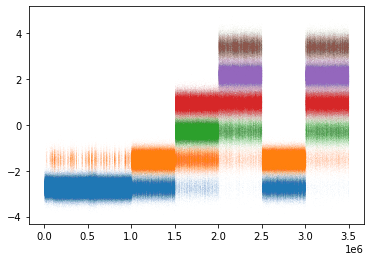

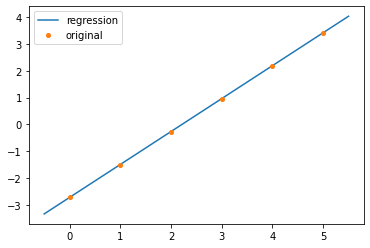

meanA : [-2.7281204  -1.49853395 -0.2689475   0.96063895  2.1902254   3.41981185]


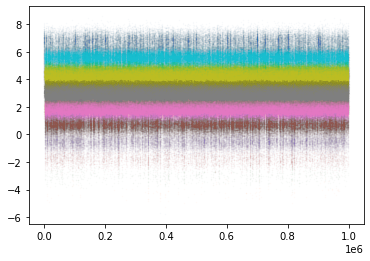

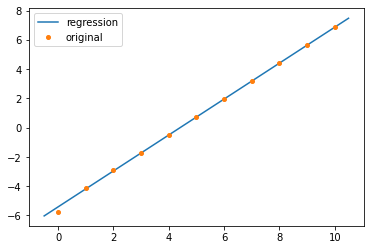

meanB : [-5.41787354 -4.19032957 -2.96278559 -1.73524161 -0.50769763  0.71984635
  1.94739033  3.17493431  4.40247829  5.63002227  6.85756625]


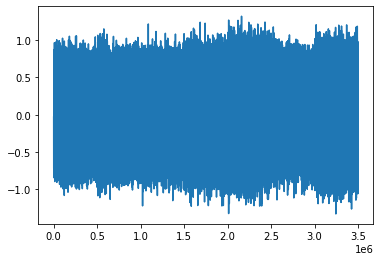

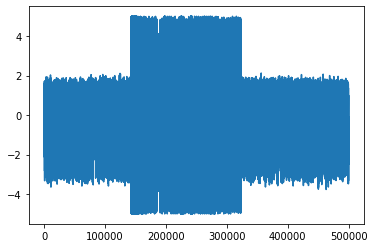

7358


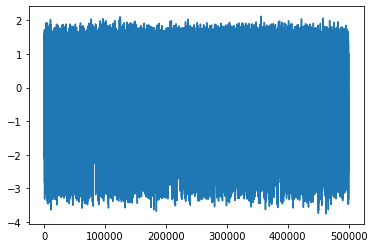

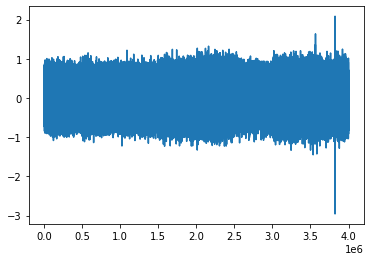

4000000
3500000


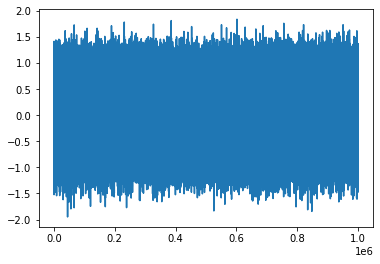

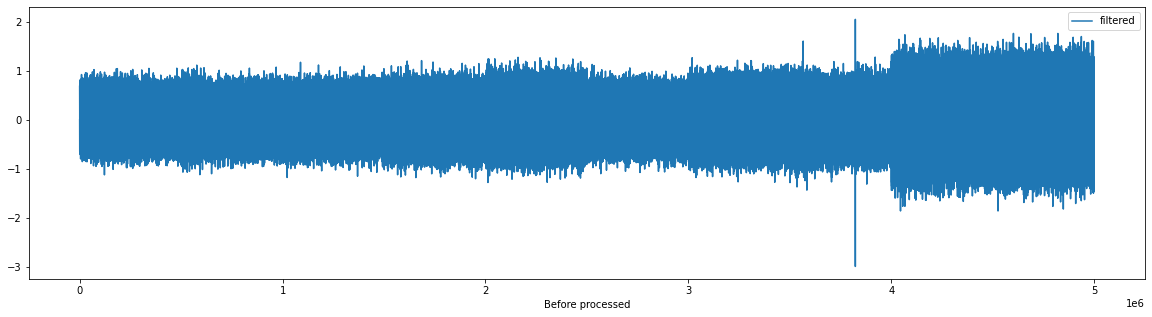

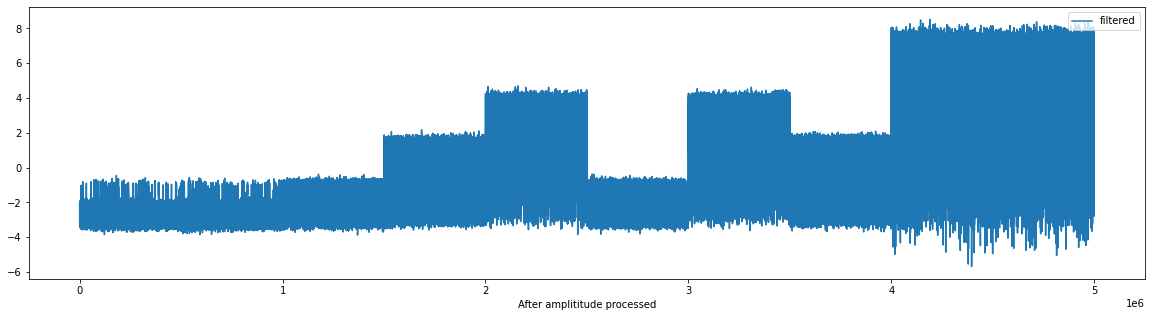

5000000


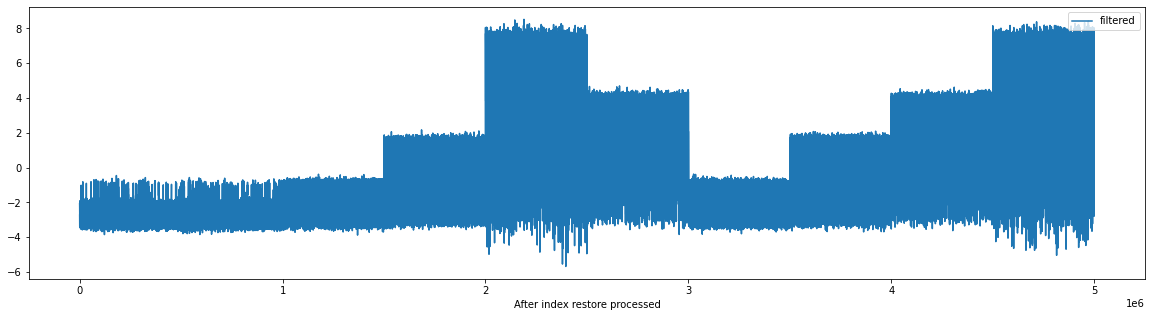

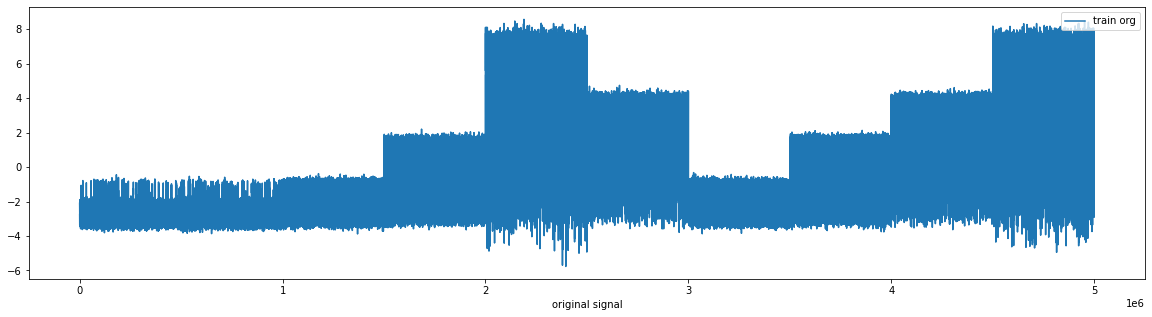

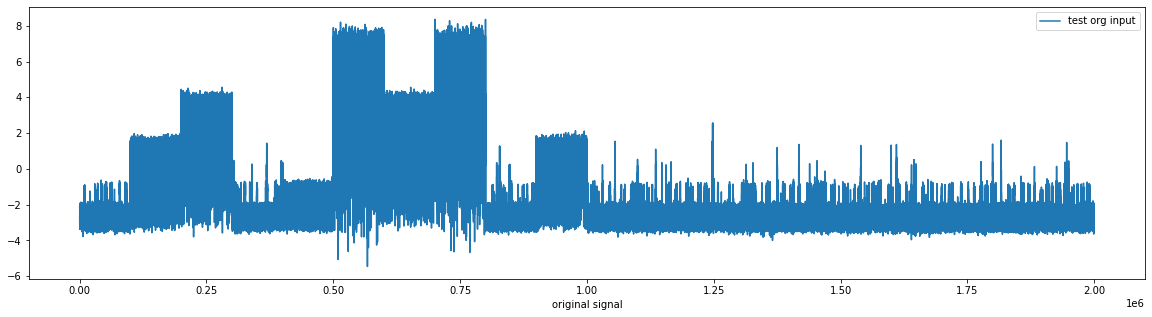

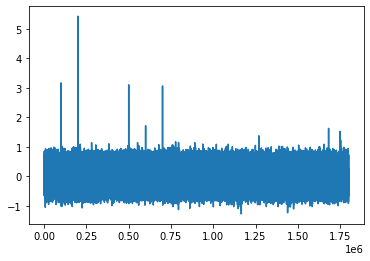

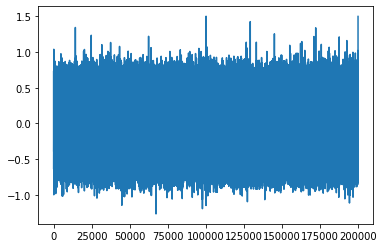

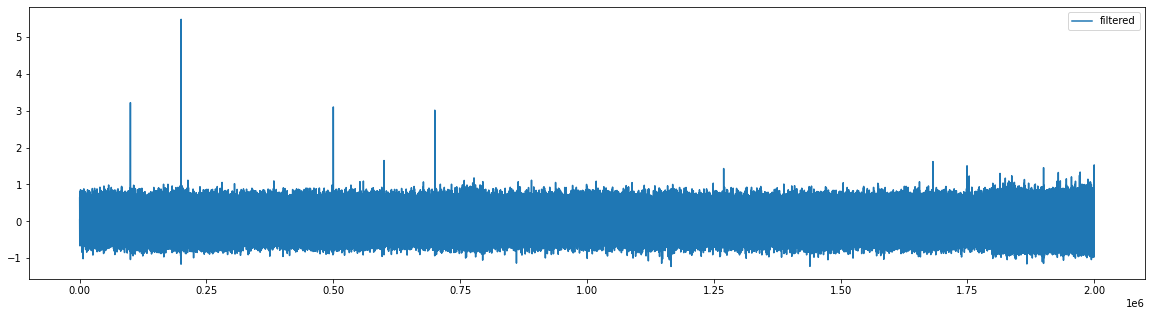

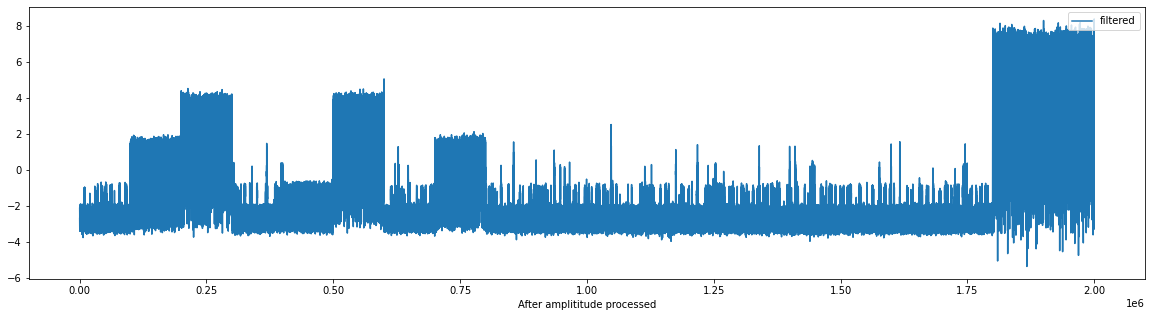

2000000


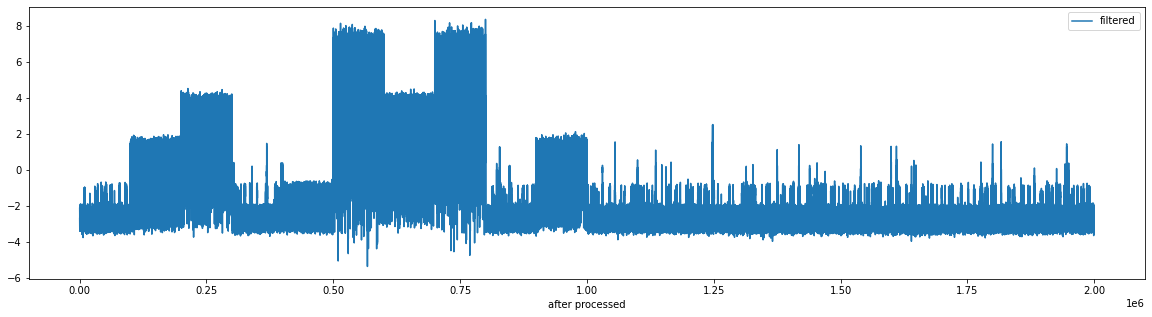

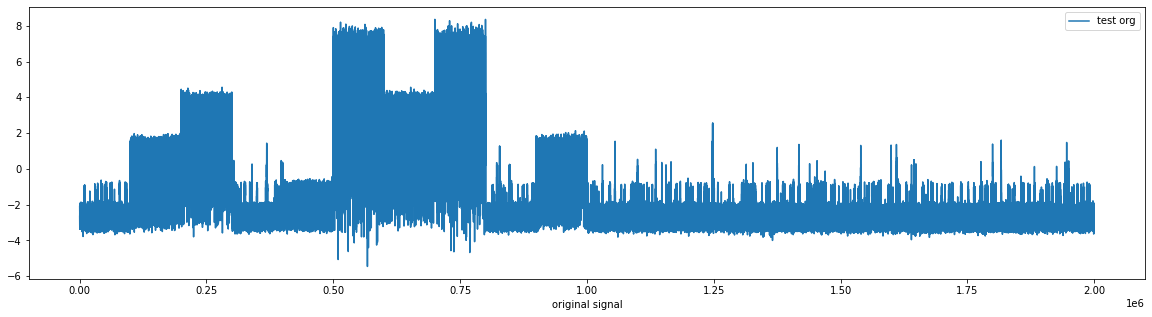

2020-05-24 21:18:01,274 INFO Reading and Normalizing Data Completed ...
2020-05-24 21:18:01,276 INFO [Reading Data] done in 17 s
2020-05-24 21:18:01,277 INFO Feature Enginnering Started ...


['signal', 'signal_shift_pos_1', 'signal_shift_neg_1', 'signal_shift_pos_2', 'signal_shift_neg_2', 'signal_shift_pos_3', 'signal_shift_neg_3', 'signal_2', 'category']
Mem. usage decreased to 133.51 MB (65.9 % reduction)


2020-05-24 21:18:06,200 INFO Feature Enginnering Completed ...
2020-05-24 21:18:06,201 INFO [Creating Features] done in 5 s
2020-05-24 21:18:06,202 INFO Training Wavenet model with 5 folds of GroupKFold Started ...


Mem. usage decreased to 45.78 MB (69.2 % reduction)
ion_switch/res/wavenet-dlr-res/CnnGRUTransformerWave-NESCAL/filterbased
5000000 5
     time    signal  open_channels  group  category
0  0.0001 -1.140625              0      0         0
1  0.0002 -1.175781              0      0         0
2  0.0003 -1.003906              0      0         0
3  0.0004 -1.290039              0      0         0
4  0.0005 -1.295898              0      0         0
weights_: [ 0.36652399  0.46106257  0.82059173  0.67983748  1.12675802  1.63577934
  2.41635544  1.71516878  1.85390282  3.33929955 12.72060713]
nums_: 0     1240152
1      985865
2      553924
3      668609
4      403410
5      277877
6      188112
7      265015
8      245183
9      136120
10      35733
Name: open_channels, dtype: int64
cb_weights_: [0.97174558 0.97174558 0.97174558 0.97174558 0.97174567 0.97176004
 0.97227024 0.97176977 0.97179906 0.97596    1.27771292]
(1250, 4000, 11)
(1250, 4000, 9)
Loading RF model:  ion_switch/res/RFC/RF100-

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   24.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.5s finished


Mem. usage decreased to 167.85 MB (61.4 % reduction)
Mem. usage decreased to 61.04 MB (68.6 % reduction)
Mem. usage decreased to 41.96 MB (61.4 % reduction)
X_aug shape 1: (1000, 4000, 20)
X_aug shape 2: (1000, 4000, 21)
unique train_x[8]: [0. 1.]
test shape after roll diff: (500, 4000, 21)
train_x shape 3:  (2000, 4000, 21)
train_y shape 3:  (2000, 4000, 11)
model initilization done!


2020-05-24 21:19:33,399 INFO Training fold 1 completed. macro f1 score : 0.94368


Loading RF model:  ion_switch/res/RFC/RF100-D12newreal/rf-f1-tn100-dn12.pkl


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   25.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.4s finished


Mem. usage decreased to 167.85 MB (61.4 % reduction)
Mem. usage decreased to 61.04 MB (68.6 % reduction)
Mem. usage decreased to 41.96 MB (61.4 % reduction)
X_aug shape 1: (1000, 4000, 20)
X_aug shape 2: (1000, 4000, 21)
unique train_x[8]: [0. 1.]
test shape after roll diff: (500, 4000, 21)
train_x shape 3:  (2000, 4000, 21)
train_y shape 3:  (2000, 4000, 11)
model initilization done!


2020-05-24 21:20:54,779 INFO Training fold 2 completed. macro f1 score : 0.94470


Loading RF model:  ion_switch/res/RFC/RF100-D12newreal/rf-f2-tn100-dn12.pkl


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   24.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.4s finished


Mem. usage decreased to 167.85 MB (61.4 % reduction)
Mem. usage decreased to 61.04 MB (68.6 % reduction)
Mem. usage decreased to 41.96 MB (61.4 % reduction)
X_aug shape 1: (1000, 4000, 20)
X_aug shape 2: (1000, 4000, 21)
unique train_x[8]: [0. 1.]
test shape after roll diff: (500, 4000, 21)
train_x shape 3:  (2000, 4000, 21)
train_y shape 3:  (2000, 4000, 11)
model initilization done!


2020-05-24 21:22:14,501 INFO Training fold 3 completed. macro f1 score : 0.94281


Loading RF model:  ion_switch/res/RFC/RF100-D12newreal/rf-f3-tn100-dn12.pkl


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   25.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.2s finished


Mem. usage decreased to 167.85 MB (61.4 % reduction)
Mem. usage decreased to 61.04 MB (68.6 % reduction)
Mem. usage decreased to 41.96 MB (61.4 % reduction)
X_aug shape 1: (1000, 4000, 20)
X_aug shape 2: (1000, 4000, 21)
unique train_x[8]: [0. 1.]
test shape after roll diff: (500, 4000, 21)
train_x shape 3:  (2000, 4000, 21)
train_y shape 3:  (2000, 4000, 11)
model initilization done!


2020-05-24 21:23:35,308 INFO Training fold 4 completed. macro f1 score : 0.94314


Loading RF model:  ion_switch/res/RFC/RF100-D12newreal/rf-f4-tn100-dn12.pkl


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   25.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.5s finished


Mem. usage decreased to 167.85 MB (61.4 % reduction)
Mem. usage decreased to 61.04 MB (68.6 % reduction)
Mem. usage decreased to 41.96 MB (61.4 % reduction)
X_aug shape 1: (1000, 4000, 20)
X_aug shape 2: (1000, 4000, 21)
unique train_x[8]: [0. 1.]
test shape after roll diff: (500, 4000, 21)
train_x shape 3:  (2000, 4000, 21)
train_y shape 3:  (2000, 4000, 11)
model initilization done!


2020-05-24 21:24:57,964 INFO Training fold 5 completed. macro f1 score : 0.94384
2020-05-24 21:25:03,965 INFO Training completed. oof macro f1 score : 0.94366


,time,open_channels
0,500.000092,0
1,500.000214,0
2,500.000305,0
3,500.000397,0
4,500.000488,0


2020-05-24 21:25:10,285 INFO Training completed ...
2020-05-24 21:25:10,286 INFO [Running Wavenet model] done in 424 s


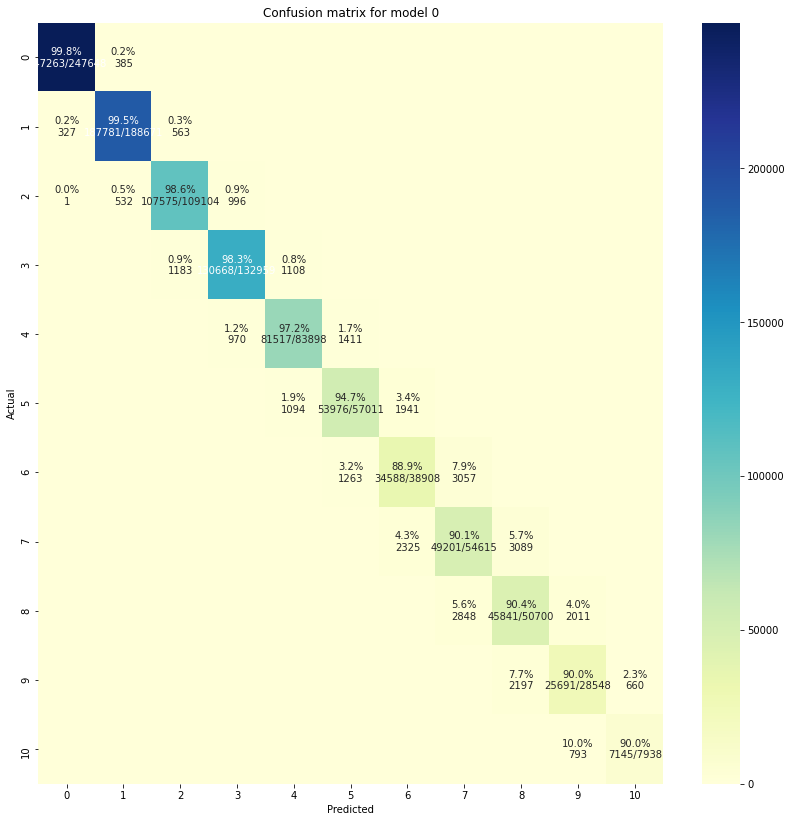

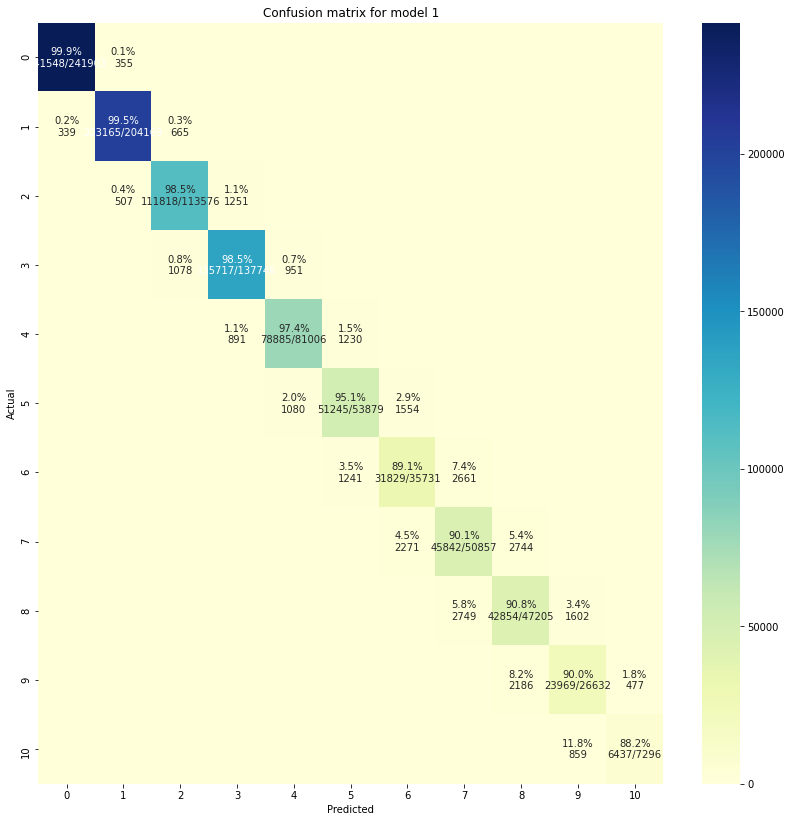

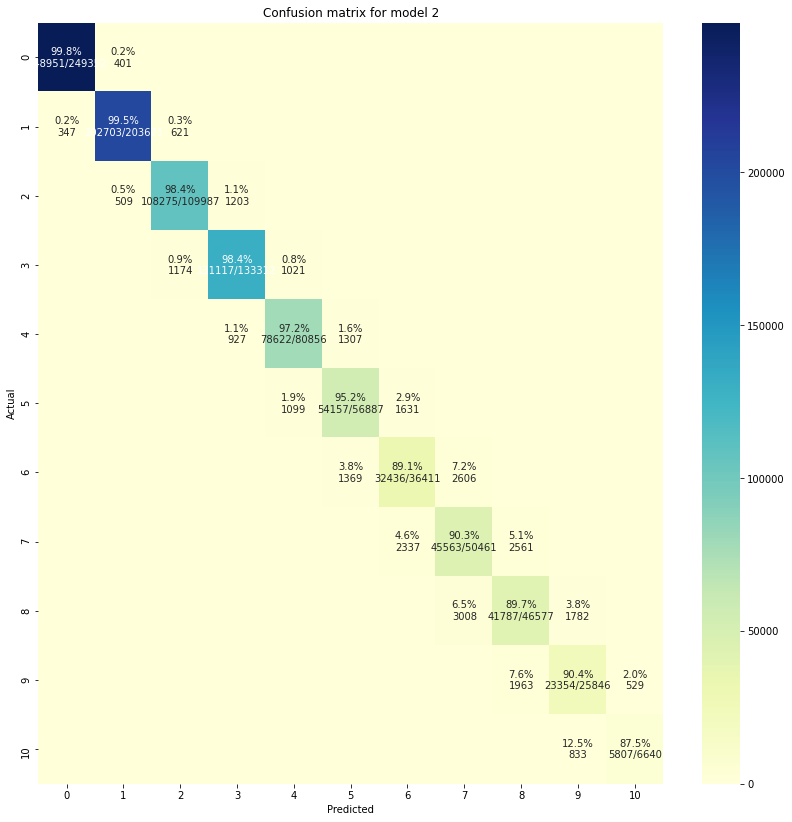

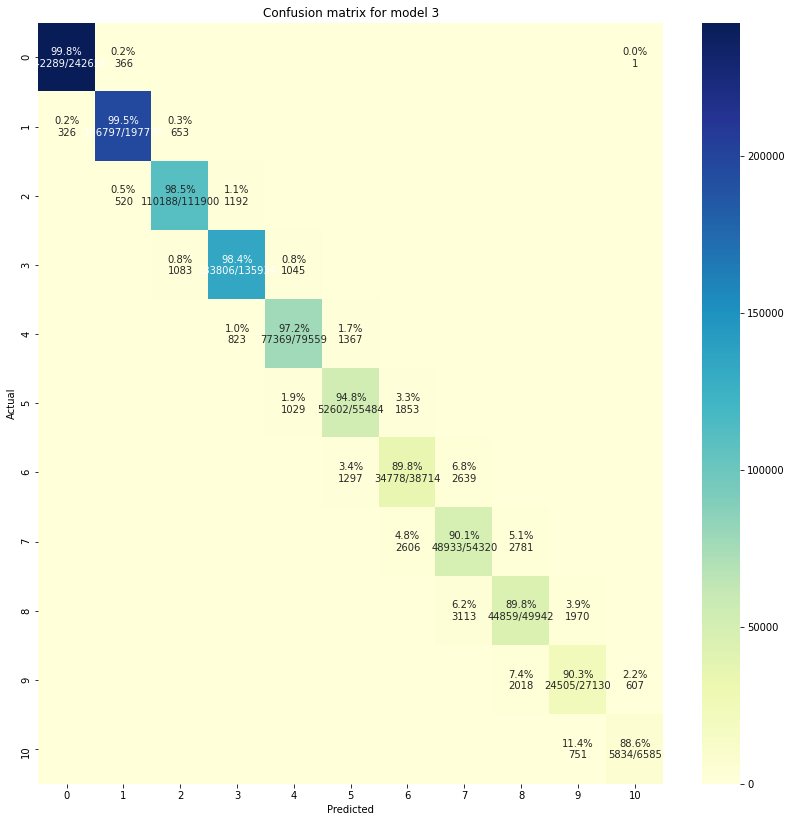

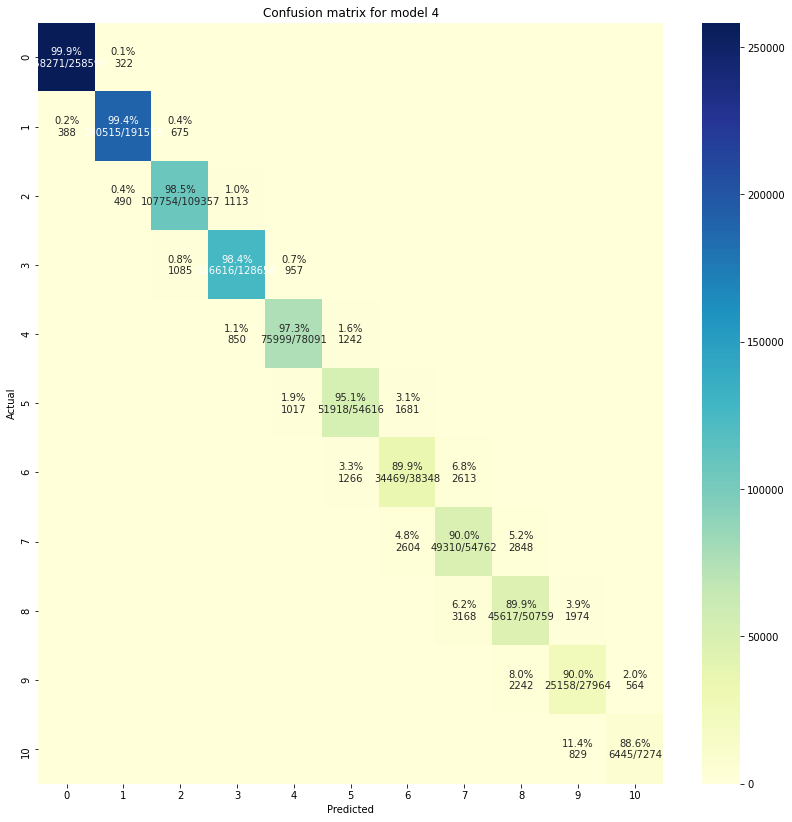

In [75]:
run_everything(fe_config)

In [76]:
print("test")

test
